In [3]:
# General
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1 #0.75
mpl.rcParams['lines.markersize'] = 3 #
mpl.rcParams['xtick.labelsize'] = 10 #'small'
mpl.rcParams['ytick.labelsize'] = 10 #'small'
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 10 #'small'
mpl.rcParams['axes.labelpad'] = 5 #
mpl.rcParams['axes.titlesize'] = 12 #'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.fontsize'] = 10 #'small'
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.titlesize'] = 12 #'small'
mpl.rcParams['figure.figsize'] = (8, 3) #
mpl.rcParams['figure.subplot.wspace'] = 0.25 #
mpl.rcParams['figure.subplot.hspace'] = 0.25 #

# Neuro
import mne
from ptsa.data.TimeSeriesX import TimeSeries 
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
sys.path.append('/home1/dscho/code/projects/connectivity_reinstatement')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
import connectivity_reinstatement
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

In [2]:
import cmlreaders
from cmlreaders import CMLReader
sys.path.insert(0, '/home1/esolo/notebooks/codebases/')
import CML_stim_pipeline
from loc_toolbox import get_region, update_pairs
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MorletWaveletFilter

In [8]:
reload(connectivity_reinstatement)

<module 'connectivity_reinstatement' from '/home1/dscho/code/projects/connectivity_reinstatement/connectivity_reinstatement.py'>

In [4]:
# Load RAM dataset
r1_df = CMLReader.get_data_index("r1")

In [5]:
# Get experiment subs
expmt = 'FR1'
subjs = r1_df.loc[r1_df.experiment==expmt].subject.unique()
print('Got {} subjects for {}'.format(len(subjs), expmt))

Got 274 subjects for FR1


In [6]:
#test_subjs = subjs[np.random.permutation(np.arange(len(subjs)))[:30]]
test_subjs = ['R1223E', 'R1446T', 'R1416T', 'R1318N', 'R1020J', 'R1354E',
              'R1373T', 'R1336T', 'R1347D', 'R1377M', 'R1226D', 'R1146E',
              'R1003P', 'R1138T', 'R1286J', 'R1268T', 'R1032D', 'R1189M',
              'R1221P', 'R1134T', 'R1153T', 'R1089P', 'R1299T', 'R1170J',
              'R1342M', 'R1247P', 'R1274T', 'R1193T', 'R1277J', 'R1378T']

In [16]:
# Get subject info
subj = 'R1111M'
#subj = 'R1355T'

for subj in test_subjs:
    sessions = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).session.tolist()
    mont = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).montage.iat[0]
    lclz = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).localization.iat[0]

    n_mont = len(np.unique(r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).montage))
    n_lclz = len(np.unique(r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).localization))
    assert (n_mont==1) & (n_lclz==1)

    print(subj, mont, lclz, sessions)

R1223E 0 0 [0, 1, 2]
R1446T 0 0 [0]
R1416T 0 0 [0, 1]
R1318N 0 0 [0]
R1020J 0 0 [0]
R1354E 0 0 [0, 1]
R1373T 0 0 [0]
R1336T 0 0 [0, 1]
R1347D 0 0 [2, 3, 4]
R1377M 0 0 [0, 1, 3, 4]
R1226D 0 0 [0, 1]
R1146E 0 0 [0, 1, 2]
R1003P 0 0 [0, 1]
R1138T 0 0 [0]
R1286J 0 0 [0]
R1268T 0 0 [0]
R1032D 0 0 [0]
R1189M 0 0 [0, 1, 2]
R1221P 0 0 [1]
R1134T 0 0 [0, 1, 2]
R1153T 0 0 [0, 1, 2]
R1089P 0 0 [0]
R1299T 0 0 [0, 1, 4, 5, 6, 7, 8, 9]
R1170J 1 0 [0, 1, 2]
R1342M 0 0 [0, 1]
R1247P 0 0 [0]
R1274T 0 0 [0]
R1193T 0 0 [0, 1, 2]
R1277J 1 0 [0]
R1378T 0 0 [0, 1, 2, 3]


In [7]:
subj = 'R1223E'
sess = 0
expmt = 'FR1'
lclz = 0
mont = 0
run_time = connectivity_reinstatement.run_pipeline1(subj, sess, expmt=expmt, lclz=lclz, mont=mont)
print('Done in {:.2f} secs'.format(run_time))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1223E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1223E/tal/R1223E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /data10/RAM/subjects/R1223E/docs/electrode_categories.txt
/scratch/pwanda/electrode_categories/R1223E_electrode_categories.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1223E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1223E/eeg.noreref/R1223E_

R1223E FR1 missing localization file
CPP total time wavelet loop:  102.29422426223755
CPP total time wavelet loop:  15.708952903747559
Done in 8381.31 secs


In [24]:
reload(connectivity_reinstatement)
from connectivity_reinstatement import *

<module 'connectivity_reinstatement' from '/home1/dscho/code/projects/connectivity_reinstatement/connectivity_reinstatement.py'>

In [22]:
# Get subject info
#subj = 'R1111M'
subj = 'R1347D'

sessions = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).session.tolist()
mont = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).montage.iat[0]
lclz = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).localization.iat[0]

n_mont = len(np.unique(r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).montage))
n_lclz = len(np.unique(r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).localization))
assert (n_mont==1) & (n_lclz==1)

print(subj, mont, lclz, sessions)

R1347D 0 0 [2, 3, 4]


In [29]:
# Params.
subj='R1347D'
sess=2
expmt='FR1'
lclz=0
mont=0
notch_freqs=[60, 120]
freqs=np.logspace(np.log10(3), np.log10(110), num=22)
enc_start=200
enc_stop=1400
ret_start=-1200
ret_stop=0
morlet_width=5
buf=1000
recdiff_buf=1500
log_power=True
z_power_across_events=True
z_plv_degrees_across_events=True
save_outputs=True
output_dir='/scratch/dscho/connectivity_reinstatement/data'

In [27]:
pairs, pairs_keep_inds = get_pairs(subj=subj, expmt=expmt)

In [33]:
def rectime_diff(x):
    """Return the ms elapsed since the start of the recall
    period or the onset of the previous recalled word.
    """
    x = list(x)
    return [x[0]] + list(np.diff(x))
reader = CMLReader(subject=subj, 
                   experiment=expmt, 
                   session=sess,
                   localization=lclz, 
                   montage=mont)
evs = reader.load('events')
enc_evs_ = evs.query(("type=='WORD'")).copy()
ret_evs_ = evs.query(("type=='REC_WORD'")).copy()
ret_evs_['recdiff'] = [item for sublist in ret_evs_.groupby('list').rectime.apply(lambda x: rectime_diff(x)).tolist() for item in sublist]
ret_evs_['recpos'] = [item for sublist in ret_evs_.groupby('list').item_name.apply(lambda x: list(np.arange(len(x)))).tolist() for item in sublist]
ret_evs_ = ret_evs_.loc[ret_evs_.recdiff>=recdiff_buf] # only look at words with at least 1500ms between retrieval times

In [41]:
enc_evs_.shape

(156, 29)

In [314]:
reader = CMLReader(subject='R1347D', 
                   experiment='FR1', 
                   session=3,
                   localization=0, 
                   montage=0)

In [316]:
evs = reader.load('events')
enc_evs = evs.query(("type=='WORD'")).copy()
ret_evs = evs.query(("type=='REC_WORD'")).copy()

In [329]:
reader.load_eeg(events=ret_evs, rel_start=0, rel_stop=100, scheme=reader.load('pairs'))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 158 but corresponding boolean dimension is 160

In [170]:
#eeg_enc = reader.load_eeg(events=enc_evs_, rel_start=-buf+enc_start, rel_stop=enc_stop+buf, scheme=pairs.loc[pairs_keep_inds])

In [30]:
enc_evs, ret_evs, _, enc_phase, _, ret_phase = get_enc_ret_wavelet_power_phase(
        subj=subj,
        expmt=expmt,
        sessions=sess,
        pairs=pairs,
        lclz=lclz,
        mont=mont,
        pairs_keep_inds=pairs_keep_inds,
        notch_freqs=notch_freqs,
        freqs=freqs,
        enc_start=enc_start,
        enc_stop=enc_stop,
        ret_start=ret_start,
        ret_stop=ret_stop,
        morlet_width=morlet_width,
        buf=buf,
        recdiff_buf=recdiff_buf,
        log_power=log_power,
        z_power_across_events=z_power_across_events,
        save_outputs=save_outputs,
        output_dir=output_dir)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 158 but corresponding boolean dimension is 160

In [191]:
# append files
output_dir = '/scratch/dscho/connectivity_reinstatement/data'
complete_subjs = OrderedDict()
for subj in subjs:
    sessions = r1_df.query("(subject=='{}') & (experiment=='{}')".format(subj, expmt)).session.tolist()
    for sess in sessions:
        enc_evs_f = os.path.join(output_dir, 'events', 'encoding_events-{}-ses{}.pkl'.format(subj, sess))
        ret_evs_f = os.path.join(output_dir, 'events', 'retrieval_events-{}-ses{}-1500ms_recall_buffer.pkl'.format(subj, sess))
        enc_power_f = os.path.join(output_dir, 'wavelet', 
                                   'encoding_power-freq_event_elec-{}-ses{}-200_to_1400_buf1000ms-1000Hz-notch60_120Hz-5cycles-22log10freqs_3.0_to_110.0Hz-log10_power-z_across_events.pkl'
                                   .format(subj, sess))
        ret_power_f = os.path.join(output_dir, 'wavelet', 
                                   'retrieval_power-freq_event_elec-{}-ses{}--1200_to_0_buf1000ms-1000Hz-notch60_120Hz-5cycles-22log10freqs_3.0_to_110.0Hz-log10_power-z_across_events.pkl'
                                   .format(subj, sess))
        enc_plv_degrees_f = os.path.join(output_dir, 'plvs', 'encoding_plv_degrees-freq_event_elec-{}-ses{}-z_across_events.pkl'.format(subj, sess))
        ret_plv_degrees_f = os.path.join(output_dir, 'plvs', 'retrieval_plv_degrees-freq_event_elec-{}-ses{}-z_across_events.pkl'.format(subj, sess))
        if np.all((os.path.exists(enc_evs_f), 
                   os.path.exists(ret_evs_f),
                   os.path.exists(enc_power_f), 
                   os.path.exists(ret_power_f), 
                   os.path.exists(enc_plv_degrees_f), 
                   os.path.exists(ret_plv_degrees_f))):
            if subj not in complete_subjs:
                complete_subjs[subj] = OrderedDict()
            complete_subjs[subj][sess] = {'enc_evs_f': enc_evs_f,
                                          'ret_evs_f': ret_evs_f,
                                          'enc_power_f': enc_power_f,
                                          'ret_power_f': ret_power_f,
                                          'enc_plv_degrees_f': enc_plv_degrees_f,
                                          'ret_plv_degrees_f': ret_plv_degrees_f}
            print('Done!', subj, sess)
        elif np.any((os.path.exists(enc_evs_f), 
                     os.path.exists(ret_evs_f),
                     os.path.exists(enc_power_f), 
                     os.path.exists(ret_power_f), 
                     os.path.exists(enc_plv_degrees_f), 
                     os.path.exists(ret_plv_degrees_f))):
            print(subj, sess, os.path.exists(enc_evs_f), 
                              os.path.exists(ret_evs_f),
                              os.path.exists(enc_power_f), 
                              os.path.exists(ret_power_f), 
                              os.path.exists(enc_plv_degrees_f), 
                              os.path.exists(ret_plv_degrees_f))
            
print(len(complete_subjs.keys()), np.sum([len(x) for x in complete_subjs.values()]))

R1003P 0 True True False False True True
R1003P 1 True True False False True True
R1089P 0 True True False False True True
Done! R1134T 0
Done! R1134T 1
Done! R1134T 2
Done! R1138T 0
Done! R1146E 0
Done! R1146E 1
Done! R1146E 2
Done! R1153T 0
Done! R1153T 1
Done! R1153T 2
Done! R1170J 0
Done! R1170J 1
Done! R1170J 2
Done! R1189M 1
Done! R1193T 0
Done! R1193T 1
Done! R1193T 2
R1221P 1 True True False False True True
Done! R1223E 0
Done! R1223E 1
Done! R1223E 2
Done! R1226D 0
Done! R1226D 1
Done! R1247P 0
Done! R1268T 0
Done! R1274T 0
Done! R1286J 0
R1299T 0 True True True True False False
R1299T 1 True True True True False False
Done! R1299T 4
Done! R1299T 7
Done! R1299T 8
Done! R1299T 9
Done! R1336T 0
Done! R1336T 1
Done! R1342M 0
Done! R1416T 0
Done! R1446T 0
18 35


In [192]:
# Save word events.
for subj in complete_subjs.keys():
    for sess in complete_subjs[subj].keys():
        enc_evs = dio.open_pickle(complete_subjs[subj][sess]['enc_evs_f'])
        ret_evs = dio.open_pickle(complete_subjs[subj][sess]['ret_evs_f'])
        complete_subjs[subj][sess]['word_pairs_f'] = os.path.join(output_dir, 'events', 'encoding_retrieval_word_pairs-{}-ses{}.pkl'.format(subj, sess))
        if not os.path.exists(complete_subjs[subj][sess]['word_pairs_f']):
            print(subj, sess)
            word_pairs = get_word_pairs(subj, sess, enc_evs, ret_evs, save_outputs=True)

R1193T 1
R1446T 0


In [168]:
reload(connectivity_reinstatement)
from connectivity_reinstatement import *

In [193]:
start_time = time()

for subj in complete_subjs.keys():
    for sess in complete_subjs[subj].keys():
        word_pairs = dio.open_pickle(complete_subjs[subj][sess]['word_pairs_f'])
        enc_power = dio.open_pickle(complete_subjs[subj][sess]['enc_power_f'])
        ret_power = dio.open_pickle(complete_subjs[subj][sess]['ret_power_f'])
        enc_plv_degrees = dio.open_pickle(complete_subjs[subj][sess]['enc_plv_degrees_f'])
        ret_plv_degrees = dio.open_pickle(complete_subjs[subj][sess]['ret_plv_degrees_f'])
    
        neural_dat = OrderedDict([('enc', OrderedDict([('power', enc_power),
                                                       ('plv_degrees', enc_plv_degrees)])),
                                  ('ret', OrderedDict([('power', ret_power),
                                                       ('plv_degrees', ret_plv_degrees)]))])
        
        complete_subjs[subj][sess]['neural_sims_f'] = os.path.join(output_dir, 'sims', 'encoding_retrieval_word_pair-cos_sim-{}-ses{}.pkl'.format(subj, sess))
        if not os.path.exists(complete_subjs[subj][sess]['neural_sims_f']):
            print(subj, sess)
            neural_sims = get_enc_ret_sims(subj, sess, word_pairs, neural_dat, sim_type='cos_sim', save_outputs=True)
        
print('Done in {:.2f} secs'.format(time() - start_time))

R1193T 1
R1446T 0
Done in 1.12 secs


In [194]:
results = []
for subj in complete_subjs.keys():
    enc_evs = pd.DataFrame([])
    word_pairs = pd.DataFrame([])
    enc_power = np.array([])
    enc_plv_degrees = np.array([])
    power_sim = np.array([])
    plv_degrees_sim = np.array([])
    for sess in complete_subjs[subj].keys():
        enc_evs = enc_evs.append(dio.open_pickle(complete_subjs[subj][sess]['enc_evs_f']))
        word_pairs = word_pairs.append(dio.open_pickle(complete_subjs[subj][sess]['word_pairs_f']))
        
        enc_power_ = dio.open_pickle(complete_subjs[subj][sess]['enc_power_f'])
        enc_power = np.concatenate((enc_power, enc_power_), axis=1) if enc_power.size else enc_power_
        
        enc_plv_degrees_ = dio.open_pickle(complete_subjs[subj][sess]['enc_plv_degrees_f'])
        enc_plv_degrees = np.concatenate((enc_plv_degrees, enc_plv_degrees_), axis=1) if enc_plv_degrees.size else enc_plv_degrees_
        
        neural_sims = dio.open_pickle(complete_subjs[subj][sess]['neural_sims_f'])
        power_sim = np.concatenate((power_sim, neural_sims['power']), axis=0) if power_sim.size else neural_sims['power']
        plv_degrees_sim = np.concatenate((plv_degrees_sim, neural_sims['plv_degrees']), axis=0) if plv_degrees_sim.size else neural_sims['plv_degrees']
        
    enc_evs.reset_index(drop=True, inplace=True)
    word_pairs.reset_index(drop=True, inplace=True)
    #print(subj, sess, len(enc_evs), len(word_pairs), power_sim.shape, plv_degrees_sim.shape)
    
    word_pair_types = ['match', 'rem', 'nrem']
    word_pair_inds = {'match': word_pairs.query("same_word==True").index.tolist(),
                      'rem': word_pairs.query("(same_word==False) & (recalled==True)").index.tolist(),
                      'nrem': word_pairs.query("(same_word==False) & (recalled==False)").index.tolist()}
    enc_types = ['rem', 'nrem']
    recalled = enc_evs.recalled.tolist()
            
    results.append([subj, 'enc', 'rem', 'power', [np.mean(enc_power[iFreq, recalled, :]) for iFreq in range(len(freqs))]])
    results.append([subj, 'enc', 'nrem', 'power', [np.mean(enc_power[iFreq, np.invert(recalled), :]) for iFreq in range(len(freqs))]])       
    
    results.append([subj, 'enc', 'rem', 'plv_degrees', [np.mean(enc_plv_degrees[iFreq, recalled, :]) for iFreq in range(len(freqs))]])
    results.append([subj, 'enc', 'nrem', 'plv_degrees', [np.mean(enc_plv_degrees[iFreq, np.invert(recalled), :]) for iFreq in range(len(freqs))]])
    
    results.append([subj, 'sim', 'match', 'power', [np.mean(power_sim[word_pair_inds['match'], iFreq]) for iFreq in range(len(freqs))]])
    results.append([subj, 'sim', 'rem', 'power', [np.mean(power_sim[word_pair_inds['rem'], iFreq]) for iFreq in range(len(freqs))]])
    results.append([subj, 'sim', 'nrem', 'power', [np.mean(power_sim[word_pair_inds['nrem'], iFreq]) for iFreq in range(len(freqs))]])
           
    results.append([subj, 'sim', 'match', 'plv_degrees', [np.mean(plv_degrees_sim[word_pair_inds['match'], iFreq]) for iFreq in range(len(freqs))]])
    results.append([subj, 'sim', 'rem', 'plv_degrees', [np.mean(plv_degrees_sim[word_pair_inds['rem'], iFreq]) for iFreq in range(len(freqs))]])
    results.append([subj, 'sim', 'nrem', 'plv_degrees', [np.mean(plv_degrees_sim[word_pair_inds['nrem'], iFreq]) for iFreq in range(len(freqs))]])

results = pd.DataFrame(results, columns=['subject', 'task_type', 'condition', 'neural_var', 'data'])

In [201]:
freqs

array([  3.        ,   3.56131485,   4.22765448,   5.01866956,
         5.95768748,   7.07240029,   8.39568139,   9.96655493,
        11.83134669,  14.04505022,  16.67294863,  19.79253984,
        23.49582201,  27.8920066 ,  33.11073908,  39.30592225,
        46.66025485,  55.39061948,  65.75447854,  78.05746692,
        92.66240533, 110.        ])

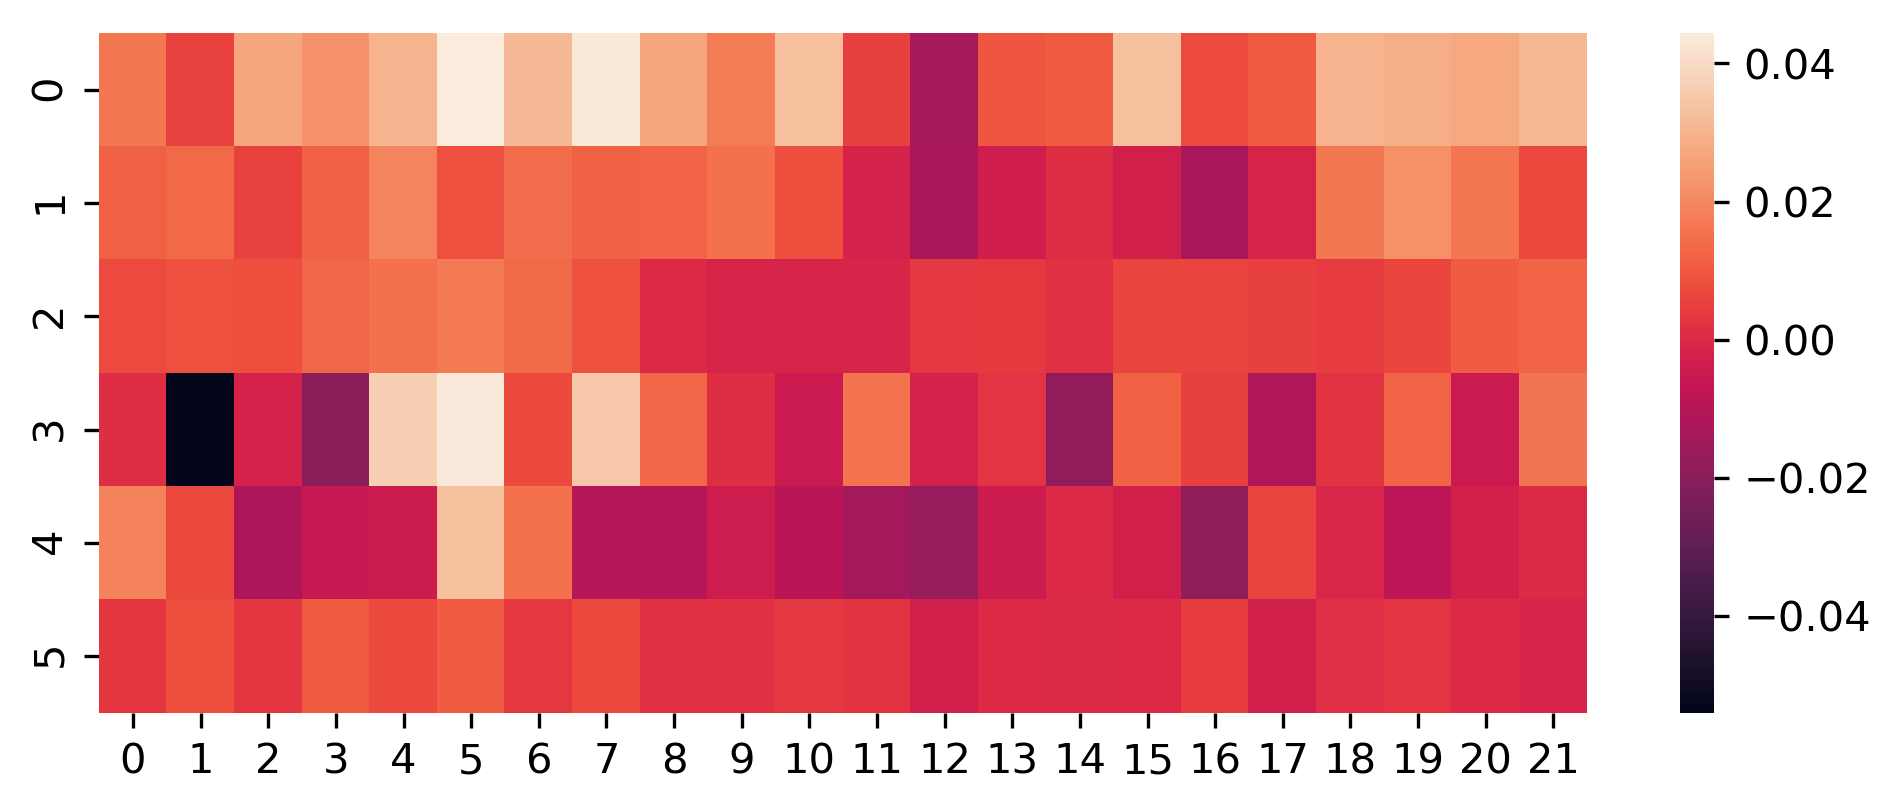

In [200]:
sns.heatmap(np.array(results.loc[results.subject=='R1134T'].data.tolist())[4:, :])

In [214]:
df.query("(task_type=='enc') & (condition=='rem') & (neural_var=='power')").data.iat[0]

[-0.5411687,
 -0.44665158,
 -0.48506847,
 -0.55952,
 -0.7998148,
 -0.841473,
 -0.7091514,
 -0.6413981,
 -0.7820106,
 -0.678956,
 -0.39414003,
 -0.24618681,
 -0.18300137,
 -0.15061887,
 -0.094691575,
 0.15118515,
 0.2290802,
 0.29571384,
 0.27042764,
 0.15383844,
 0.14450459,
 0.0111654755]

In [ ]:
np.append()

In [224]:
contrasts = {'enc': 
                {'rem_vs_nrem': {'power': [], 'plv_degrees': []}},
             'sim':
                {'match_vs_rem': {'power': [], 'plv_degrees': []},
                 'match_vs_nrem': {'power': [], 'plv_degrees': []},
                 'rem_vs_nrem': {'power': [], 'plv_degrees': []}}
            }
for subj, df in results.groupby(['subject']):
    for neural_var in ['power', 'plv_degrees']:
        contrasts['enc']['rem_vs_nrem'][neural_var].append([df.query("(task_type=='enc') & (condition=='rem') & (neural_var=='{}')".format(neural_var)).data.iat[0],
                                                            df.query("(task_type=='enc') & (condition=='nrem') & (neural_var=='{}')".format(neural_var)).data.iat[0]])
        contrasts['sim']['match_vs_rem'][neural_var].append([df.query("(task_type=='sim') & (condition=='match') & (neural_var=='{}')".format(neural_var)).data.iat[0],
                                                             df.query("(task_type=='sim') & (condition=='rem') & (neural_var=='{}')".format(neural_var)).data.iat[0]])
        contrasts['sim']['match_vs_nrem'][neural_var].append([df.query("(task_type=='sim') & (condition=='match') & (neural_var=='{}')".format(neural_var)).data.iat[0],
                                                              df.query("(task_type=='sim') & (condition=='nrem') & (neural_var=='{}')".format(neural_var)).data.iat[0]])
        contrasts['sim']['rem_vs_nrem'][neural_var].append([df.query("(task_type=='sim') & (condition=='rem') & (neural_var=='{}')".format(neural_var)).data.iat[0],
                                                            df.query("(task_type=='sim') & (condition=='nrem') & (neural_var=='{}')".format(neural_var)).data.iat[0]])
for task in contrasts.keys():
    for con in contrasts[task].keys():
        for nvar in contrasts[task][con].keys():
            contrasts[task][con][nvar] = np.array(contrasts[task][con][nvar]) # subj x contrast x freq
            dat = contrasts[task][con][nvar]
            print(task, con, nvar)

enc rem_vs_nrem power
enc rem_vs_nrem plv_degrees
sim match_vs_rem power
sim match_vs_rem plv_degrees
sim match_vs_nrem power
sim match_vs_nrem plv_degrees
sim rem_vs_nrem power
sim rem_vs_nrem plv_degrees


In [226]:
dat = contrasts['enc']['rem_vs_nrem']['power']
dat.shape

(18, 2, 22)

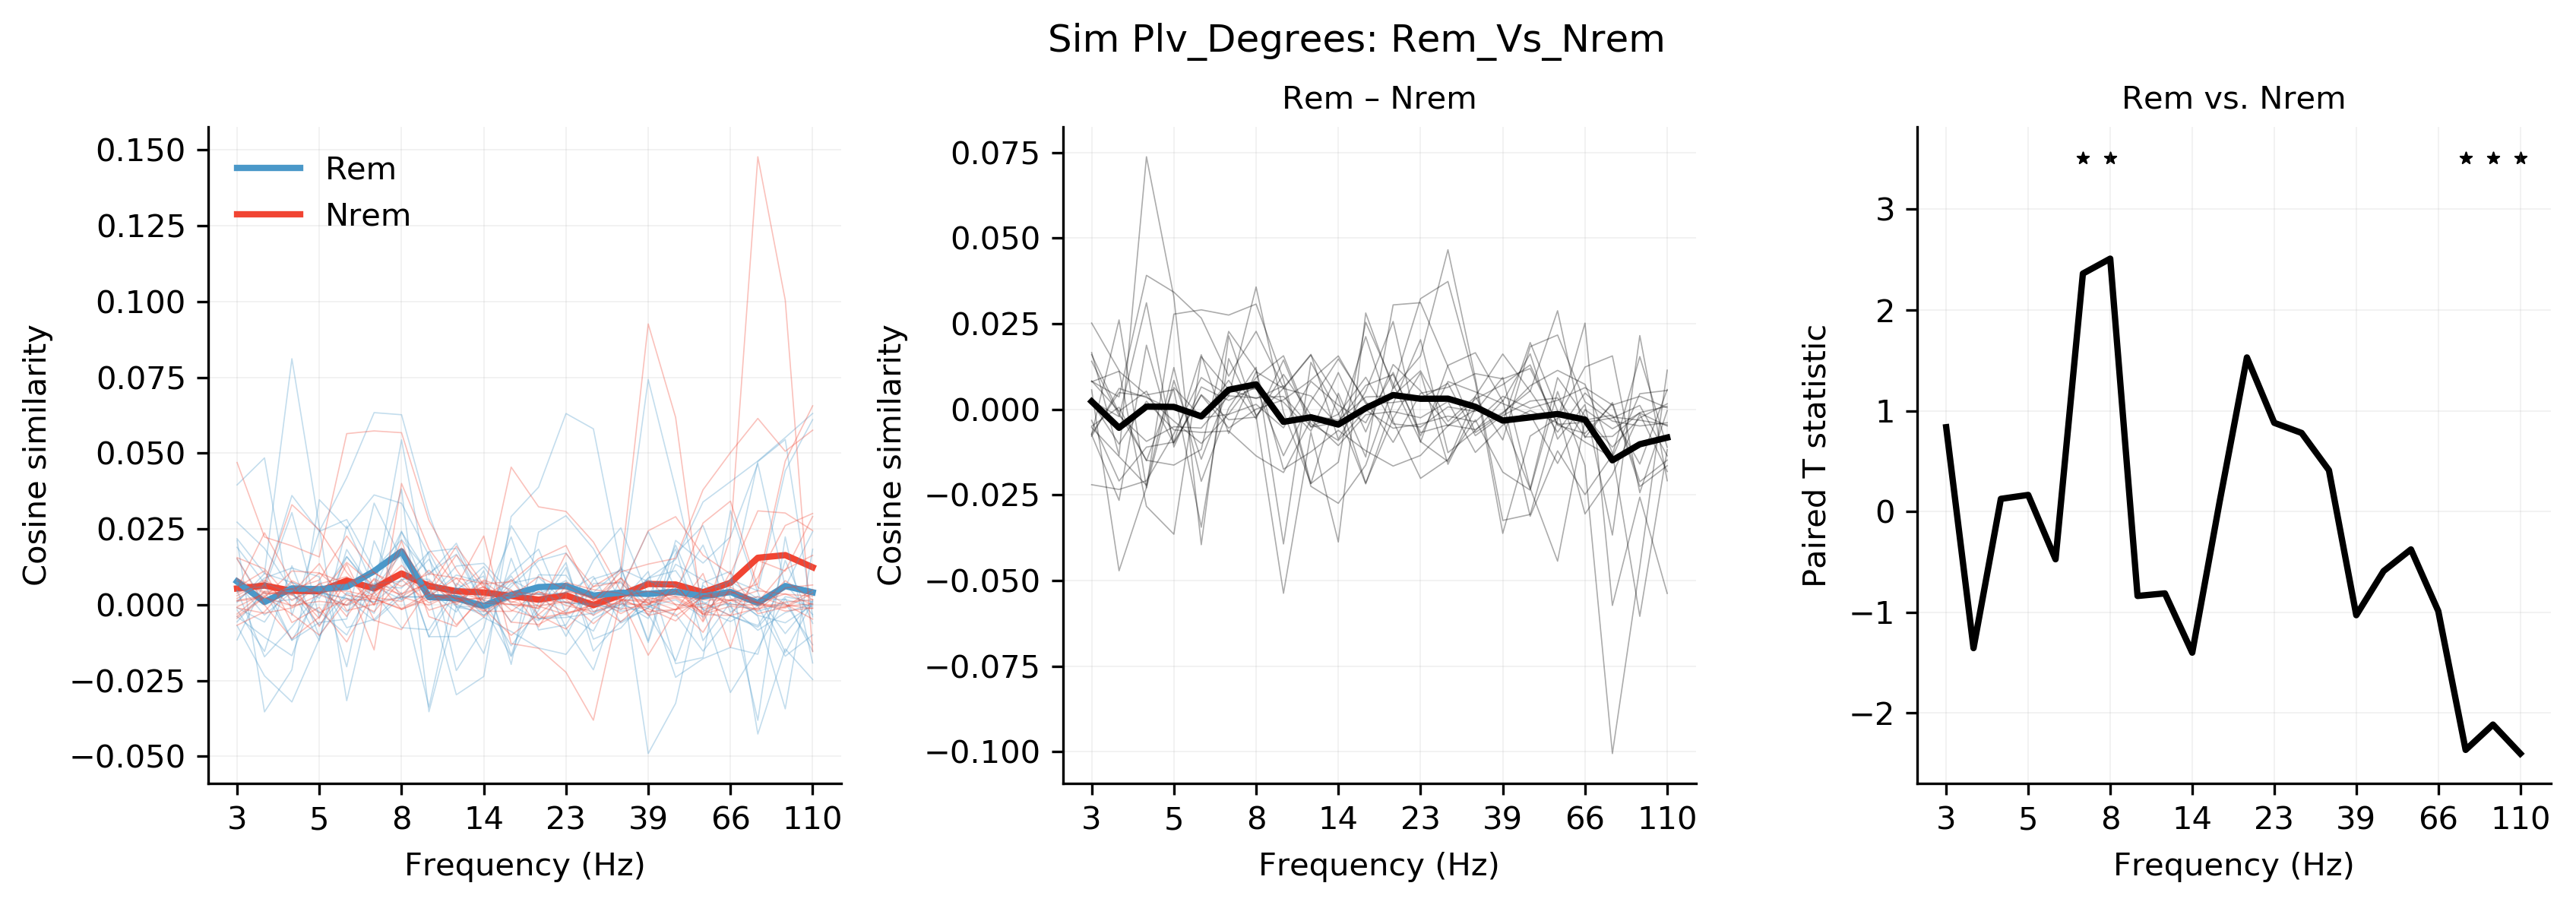

In [309]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)
tickfs = 10
labelfs = 10
figfs = 12

task = 'sim'
con = 'rem_vs_nrem'
nvar = 'plv_degrees'
alpha = 0.05

dat = contrasts[task][con][nvar]
if task == 'enc':
    ylab = 'Z-score'
elif task == 'sim':
    ylab = 'Cosine similarity'

i = 0
for subj in np.unique(results.subject):
    ax[i].plot(np.arange(len(freqs)), results.query("(subject=='{}') & (task_type=='{}') & (condition=='{}') & (neural_var=='{}')".format(subj, task, con.split('_')[0], nvar)).data.iat[0],
               linewidth=0.4, color=colors[0], alpha=0.33)
for subj in np.unique(results.subject):
    ax[i].plot(np.arange(len(freqs)), results.query("(subject=='{}') & (task_type=='{}') & (condition=='{}') & (neural_var=='{}')".format(subj, task, con.split('_')[2], nvar)).data.iat[0],
               linewidth=0.4, color=colors[1], alpha=0.33)
ax[i].plot(np.arange(len(freqs)), np.mean(dat[:, 0, :], axis=0), linewidth=2, color=colors[0], label=con.split('_')[0].title(), zorder=-1) 
ax[i].plot(np.arange(len(freqs)), np.mean(dat[:, 1, :], axis=0), linewidth=2, color=colors[1], label=con.split('_')[2].title(), zorder=-2) 
ax[i].set_ylabel(ylab, fontsize=labelfs, labelpad=5)
ax[i].legend(loc=2)
#ax[i].set_title(con.split('_')[0].title(), fontsize=labelfs, y=1)

i = 1
for iSubj in range(dat.shape[0]):
    ax[i].plot(np.arange(len(freqs)), dat[iSubj, 0, :] - dat[iSubj, 1, :],
               linewidth=0.4, color='k', alpha=0.33)
ax[i].plot(np.arange(len(freqs)), np.mean(dat[:, 0, :], axis=0) - np.mean(dat[:, 1, :], axis=0), linewidth=2, color='k', label=con.split('_')[0].title()) 
ax[i].set_ylabel(ylab, fontsize=labelfs, labelpad=5)
ax[i].set_title('{} – {}'.format(con.split('_')[0].title(), con.split('_')[2].title()), fontsize=labelfs, y=1)

i = 2
tvals, pvals = stats.ttest_rel(dat[:, 0, :], dat[:, 1, :], axis=0)
pval_vec1 = np.ones(len(freqs)) * np.nan
pval_vec2 = np.ones(len(freqs)) * np.nan
pval_vec1[(pvals<alpha) & (pvals>=alpha/len(freqs))] = np.max(tvals) + 1
pval_vec2[pvals<alpha/len(freqs)] = np.max(tvals) + 1
ax[i].plot(np.arange(len(freqs)), tvals, linewidth=2, color='k')
ax[i].scatter(np.arange(len(freqs)), pval_vec1, marker='*', s=15, color='k', linewidth=0.5, zorder=0)
ax[i].scatter(np.arange(len(freqs)), pval_vec2, marker='*', s=30, color='k', linewidth=0.5, zorder=0)
ax[i].set_ylabel('Paired T statistic', fontsize=labelfs, labelpad=5)
ax[i].set_title('{} vs. {}'.format(con.split('_')[0].title(), con.split('_')[2].title()), fontsize=labelfs, y=1)

for i in range(len(ax)):
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3]).astype(int), fontsize=tickfs)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfs, labelpad=5)
    
fig.suptitle('{} {}: {}'.format(task, nvar, con).title(), fontsize=figfs, y=0.98)
fig.tight_layout(w_pad=1.05, rect=(0, 0, 0.95, 0.95))
fig.savefig('/scratch/dscho/connectivity_reinstatement/figs/{}-{}-{}-{}subjs.pdf'.format(task, nvar, con, len(np.unique(results.subject))))

In [252]:
dat.shape

(18, 2, 22)

In [251]:
task, con, nvar, np.mean(dat[:, 0, :], axis=0), np.mean(dat[:, 1, :], axis=0), stats.ttest_rel(dat[:, 0, :], dat[:, 1, :], axis=0)[0]

('enc',
 'rem_vs_nrem',
 'power',
 array([-0.24359526, -0.30477455, -0.3620843 , -0.40531152, -0.43061796,
        -0.3585795 , -0.28471085, -0.2556003 , -0.2556531 , -0.2461279 ,
        -0.20917784, -0.10479774, -0.00764991,  0.07199395,  0.12346898,
         0.13342294,  0.13599849,  0.19489925,  0.24547523,  0.19983168,
         0.15150395,  0.16409798], dtype=float32),
 array([ 0.04396424,  0.06465877,  0.09541464,  0.11345062,  0.1280629 ,
         0.14375693,  0.1731283 ,  0.12530181,  0.06160841,  0.07756668,
         0.07375828,  0.02653057,  0.03914615,  0.03423043, -0.00047412,
        -0.02245149, -0.03938632, -0.05099449, -0.00578744,  0.00175773,
        -0.01516034, -0.02600986], dtype=float32),
 array([-3.36114789, -3.8123369 , -4.39086199, -5.19474656, -4.68169329,
        -4.1182267 , -3.79118861, -3.14067744, -2.85294552, -3.02486933,
        -3.32276829, -1.6772176 , -0.50302612,  0.38469053,  1.22900518,
         1.19219809,  1.21795148,  1.69564893,  1.79946604,  

In [219]:
contrasts['enc']['rem_vs_nrem']['power'].shape

(18, 2, 22)

In [ ]:
# Get the neural similarity between:
# 1) matching encoding/retrieval events (i.e. same word is recalled as was studied)
# 2) non-matching encoding/retrieval events where the encoded word was successfully recalled
# 3) non-matching encoding/retrieval events where the encoded word was not recalled
bhv_types = ['match', 'rem', 'nrem']
bhv_inds = {'match': word_pairs.query("same_word==True").index.tolist(),
            'rem': word_pairs.query("(same_word==False) & (recalled==True)").index.tolist(),
            'nrem': word_pairs.query("(same_word==False) & (recalled==False)").index.tolist()}
bhv_rels = OrderedDict()
for neural_type in neural_types:
    bhv_rels[neural_type] = OrderedDict()
    for bhv_type in bhv_types:
        mus = []
        stds = []
        sems = []
        for iFreq in range(len(freqs)):
            dat = neural_sims[neural_type][bhv_inds[bhv_type], iFreq]

            mus.append(np.mean(dat))
            stds.append(np.std(dat))
            sems.append(stats.sem(dat))
        
        bhv_rels[neural_type][bhv_type] = {'mean': np.array(mus),
                                           'std': np.array(stds),
                                           'sem': np.array(sems)}

In [ ]:
recalled = enc_evs.recalled.tolist()
enc_types = ['rem', 'nrem']

enc_rels = OrderedDict()
for neural_type in neural_types:
    enc_rels[neural_type] = OrderedDict()
    for enc_type in enc_types:
        mus = []
        stds = []
        sems = []
        event_inds = recalled if enc_type=='rem' else np.invert(recalled)
        for iFreq in range(len(freqs)):
            dat = np.mean(neural_dat['enc'][neural_type][iFreq, event_inds, :], axis=1) # mean across elecs
            
            mus.append(np.mean(dat))
            stds.append(np.std(dat))
            sems.append(stats.sem(dat))
        
        enc_rels[neural_type][enc_type] = {'mean': np.array(mus),
                                           'std': np.array(stds),
                                           'sem': np.array(sems)}

## Older

In [23]:
cmlpipe = CML_stim_pipeline.cml_pipeline(subj, expmt) 
cmlpipe.set_elecs(type='bi', flag_bad_elecs=True)
pairs = cmlpipe.elecs

# Load localization for MTL subregions
pairs['roi'] = pairs['ind.region'].astype(str)
pairs['hem'] = pairs['ind.x'].apply(lambda x: 'L' if x<0 else 'R')
try:
    lclz_df = cmlpipe.reader.load('localization')
    pairs = update_pairs(lclz_df, pairs)
except FileNotFoundError:
    print('missing localization file!')
if ('das.region' in pairs.columns) and not ('stein.region' in pairs.columns):
    pairs.rename(columns={'das.region', 'stein.region'}, inplace=True)
    print('Das regions!')
if 'stein.region' in pairs.columns:
    hpc_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB']
    ec_labels = ['EC', 'ERC']
    pairs['stein.region'] = pairs['stein.region'].apply(lambda x: str(x).replace('"', ''))
    pairs.loc[pairs['stein.region'].isin(hpc_labels), 'roi'] = 'hippocampal'
    pairs.loc[pairs['stein.region'].isin(ec_labels), 'roi'] = 'entorhinal'
else:
    print('missing MTL mapping!')
    
pairs_keep_inds = pairs.query("(bad_elecs==False) & (roi!={})".format(['None', 'unknown'])).index.tolist()
print('Keeping {}/{} electrode pairs ({:.1f}%)'.format(len(pairs_keep_inds), len(pairs), 100 * len(pairs_keep_inds) / len(pairs)))

Keeping 132/158 electrode pairs (83.5%)


In [7]:
def rectime_diff(x):
    """Return the ms elapsed since the start of the recall
    period or the onset of the previous recalled word.
    """
    x = list(x)
    return [x[0]] + list(np.diff(x))

In [65]:
# Get power and phase info for each encoding and retrieval event.
start_time = time()

# freq_bands = OrderedDict([('delta', [2, 4],
#                            'theta', [4, 8],
#                            'alpha', [8, 16],
#                            'beta', [16, 32],
#                            'gammal', [32, 64],
#                            'gammah', [64, 128])])
#freqs = np.array([2**((4+i)/4) for i in range(24)])
freqs = np.logspace(np.log10(3), np.log10(110), num=22)

enc_evs = pd.DataFrame()
ret_evs = pd.DataFrame()
enc_power = np.array([])
enc_phase = np.array([])
ret_power = np.array([])
ret_phase = np.array([])
for sess in sessions[:1]:
    print('Session {}'.format(sess))
    
    reader = CMLReader(subject=subj, 
                       experiment=expmt, 
                       session=sess,
                       localization=lclz, 
                       montage=mont)
    evs = reader.load('events')
    enc_evs_ = evs.query(("type=='WORD'")).copy()
    ret_evs_ = evs.query(("type=='REC_WORD'")).copy()
    ret_evs_['recdiff'] = [item for sublist in ret_evs_.groupby('list').rectime.apply(lambda x: rectime_diff(x)).tolist() for item in sublist]
    ret_evs_['recpos'] = [item for sublist in ret_evs_.groupby('list').item_name.apply(lambda x: list(np.arange(len(x)))).tolist() for item in sublist]
    ret_evs_ = ret_evs_.loc[ret_evs_.recdiff>=1500] # only look at words with at least 1500ms between retrieval times
    
    # Get EEG
    enc_start = 200
    enc_stop = 1400
    ret_start = -1200
    ret_stop = 0
    n_cycles = 5
    buf = 1250 # ms
    eeg_enc = reader.load_eeg(events=enc_evs_, rel_start=-buf+enc_start, rel_stop=enc_stop+buf, scheme=pairs.loc[pairs_keep_inds])
    eeg_ret = reader.load_eeg(events=ret_evs_, rel_start=-buf+ret_start, rel_stop=ret_stop+buf, scheme=pairs.loc[pairs_keep_inds])
    sr = eeg_enc.samplerate
    n_buf = int(buf*sr*1e-3) # buffer size in samples
    
    # Remove line noise
    filt_freqs = [[58., 62.], [118., 122.]]
    eeg_enc_filt = eeg_enc.to_ptsa()
    eeg_ret_filt = eeg_ret.to_ptsa()
    for freq_range in filt_freqs:
        eeg_enc_filt = ButterworthFilter(timeseries=eeg_enc_filt, freq_range=freq_range, filt_type='stop', order=4).filter()
        eeg_ret_filt = ButterworthFilter(timeseries=eeg_ret_filt, freq_range=freq_range, filt_type='stop', order=4).filter()
    
    # Get spectral power and phase
    enc_power_, enc_phase_ = MorletWaveletFilter(eeg_enc_filt, freqs=freqs, width=n_cycles, output=['power', 'phase'], cpus=3).filter()
    ret_power_, ret_phase_ = MorletWaveletFilter(eeg_ret_filt, freqs=freqs, width=n_cycles, output=['power', 'phase'], cpus=3).filter()
    
    # Remove buffer timepoints
    enc_power_ = enc_power_.data[:, :, :, n_buf:-n_buf] # freq x event x elec x time
    enc_phase_ = enc_phase_.data[:, :, :, n_buf:-n_buf]
    ret_power_ = ret_power_.data[:, :, :, n_buf:-n_buf] # freq x event x elec x time
    ret_phase_ = ret_phase_.data[:, :, :, n_buf:-n_buf]
    
    # Log-transform power, take the mean over time, and Z-score across events
    enc_power_ = np.log10(enc_power_)
    ret_power_ = np.log10(ret_power_)
    
    enc_power_ = np.mean(enc_power_, axis=3) # freq x event x elec
    ret_power_ = np.mean(ret_power_, axis=3) # freq x event x elec
    
    enc_power_ = stats.zscore(enc_power_, axis=1) # Z-scored across events
    ret_power_ = stats.zscore(ret_power_, axis=1) # Z-scored across events
    
    # Combine data across sessions
    enc_evs = enc_evs.append(enc_evs_)
    ret_evs = ret_evs.append(ret_evs_)
    
    enc_power = np.concatenate((enc_power, enc_power_), axis=1) if enc_power.size else enc_power_
    enc_phase = np.concatenate((enc_phase, enc_phase_), axis=1) if enc_phase.size else enc_phase_
    ret_power = np.concatenate((ret_power, ret_power_), axis=1) if ret_power.size else ret_power_
    ret_phase = np.concatenate((ret_phase, ret_phase_), axis=1) if ret_phase.size else ret_phase_
    
enc_evs = enc_evs.reset_index(drop=True)
ret_evs = ret_evs.reset_index(drop=True)

print('Done in {:.2f} secs'.format(time() - start_time))

Session 0


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1111M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638.params.txt
/data/eeg/R1111M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  25.101227521896362
CPP total time wavelet loop:  6.937688112258911
Done in 85.00 secs


In [67]:
# Save outputs
tmp_dir = '/scratch/dscho/tmp'
dio.save_pickle(pairs.loc[pairs_keep_inds], os.path.join(tmp_dir, '{}_ses{}-pairs.pkl'.format(subj, sess)))
dio.save_pickle(enc_evs, os.path.join(tmp_dir, '{}_ses{}-enc_evs.pkl'.format(subj, sess)))
dio.save_pickle(ret_evs, os.path.join(tmp_dir, '{}_ses{}-ret_evs.pkl'.format(subj, sess)))
dio.save_pickle(enc_power.astype(np.float32), os.path.join(tmp_dir, '{}_ses{}-enc_power.pkl'.format(subj, sess)))
dio.save_pickle(ret_power.astype(np.float32), os.path.join(tmp_dir, '{}_ses{}-ret_power.pkl'.format(subj, sess)))

Saved /scratch/dscho/tmp/R1111M_ses0-pairs.pkl
Saved /scratch/dscho/tmp/R1111M_ses0-enc_evs.pkl
Saved /scratch/dscho/tmp/R1111M_ses0-ret_evs.pkl
Saved /scratch/dscho/tmp/R1111M_ses0-enc_power.pkl
Saved /scratch/dscho/tmp/R1111M_ses0-ret_power.pkl
Saved /scratch/dscho/tmp/R1111M_ses0-word_pairs.pkl


In [ ]:
# For each event, calculate a PLV at each frequency, between all electrode pairs.
# Then Z-score PLVs across events.
start_time = time()

n_elecs = enc_phase.shape[2]
elec_pairs = []
for iElec1, iElec2 in itertools.combinations(np.arange(n_elecs), 2):
    elec_pairs.append((iElec1, iElec2))
dio.save_pickle(elec_pairs, os.path.join(tmp_dir, '{}_ses{}-elec_pairs.pkl'.format(subj, sess)), verbose=False)

enc_plvs = []
for iElec1, iElec2 in elec_pairs:
    enc_plvs.append(lfp_synchrony.calc_plv(enc_phase[:, :, iElec1, :], enc_phase[:, :, iElec2, :], axis=-1))
enc_plvs = np.moveaxis(enc_plvs, 0, 2) # freq x event x elec_pair
#enc_plvs = stats.zscore(enc_plvs, axis=1) # Z-scored across events
dio.save_pickle(enc_plvs.astype(np.float32), os.path.join(tmp_dir, '{}_ses{}-enc_plvs.pkl'.format(subj, sess)), verbose=False)

ret_plvs = []
for iElec1, iElec2 in elec_pairs:
    ret_plvs.append(lfp_synchrony.calc_plv(ret_phase[:, :, iElec1, :], ret_phase[:, :, iElec2, :], axis=-1))
ret_plvs = np.moveaxis(ret_plvs, 0, 2) # freq x event x elec_pair
#ret_plvs = stats.zscore(ret_plvs, axis=1) # Z-scored across events
dio.save_pickle(ret_plvs.astype(np.float32), os.path.join(tmp_dir, '{}_ses{}-ret_evs.pkl'.format(subj, sess)), verbose=False)

dio.save_pickle('Done getting enc_plvs and ret_plvs in {:.2f} secs'.format(time() - start_time), os.path.join(tmp_dir, 'timing.txt'))
print('Done in {:.2f} secs'.format(time() - start_time))

Text(0.5, 1, 'Power ~ PLV degree')

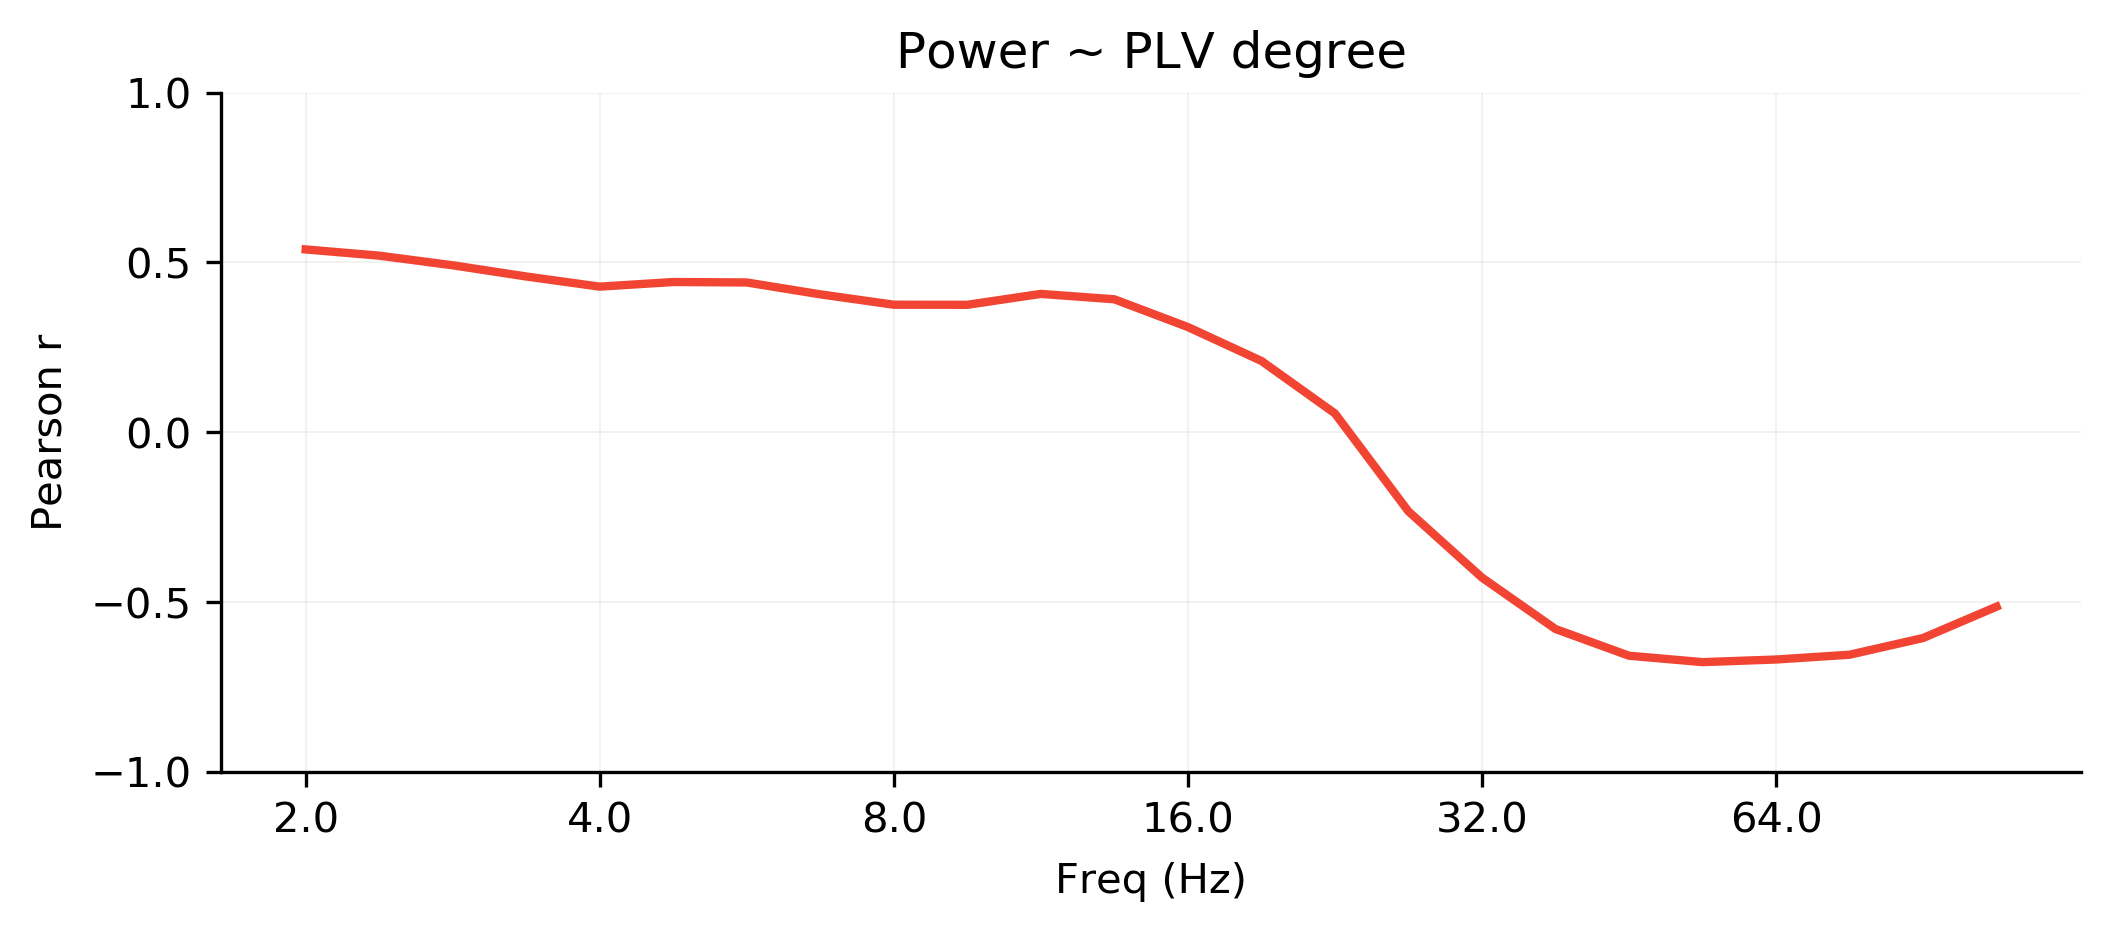

In [388]:
corrs = []
for iFreq in range(len(freqs)):
    corrs.append(stats.pearsonr(enc_power[iFreq, :, :].flatten(), enc_plv_degrees[iFreq, :, :].flatten())[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=300)

ax.plot(np.arange(len(freqs)), corrs, linewidth=2, color=colors[1])
ax.set_xticks(np.arange(len(freqs))[::4])
ax.set_xticklabels(freqs[::4])
ax.set_xlabel('Freq (Hz)', fontsize=10, labelpad=5)
ax.set_ylim([-1, 1])
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_ylabel('Pearson r', fontsize=10, labelpad=5)
ax.set_title('Power ~ PLV degree', fontsize=12, y=1)

In [244]:
# Get a list of electrode pairs involving each electrode
elec_inds = []
for iElec in range(n_elecs):
    elec_inds.append(np.where(np.array(elec_pairs)==iElec)[0])

# For each frequency and event, calculate the degree of each electrode
# (sum of PLVs) and Z-score across events.
enc_plv_degrees = []
for iFreq in range(len(freqs)):
    enc_plv_degrees_ = []
    for iEvent in range(enc_plvs.shape[1]):
        enc_plv_degrees__ = []
        for iElec in range(n_elecs):
            enc_plv_degrees__.append(np.sum(enc_plvs[iFreq, iEvent, elec_inds[iElec]]))
        enc_plv_degrees_.append(enc_plv_degrees__)
    enc_plv_degrees.append(enc_plv_degrees_)
enc_plv_degrees = stats.zscore(enc_plv_degrees, axis=1)

ret_plv_degrees = []
for iFreq in range(len(freqs)):
    ret_plv_degrees_ = []
    for iEvent in range(ret_plvs.shape[1]):
        ret_plv_degrees__ = []
        for iElec in range(n_elecs):
            ret_plv_degrees__.append(np.sum(ret_plvs[iFreq, iEvent, elec_inds[iElec]]))
        ret_plv_degrees_.append(ret_plv_degrees__)
    ret_plv_degrees.append(ret_plv_degrees_)
ret_plv_degrees = stats.zscore(ret_plv_degrees, axis=1)

In [276]:
# Store neural data in a handy dictionary.
# All are freq x event x elec and are Z-scored across events.
neural_dat = {'enc': {'power': enc_power,
                      'plvs': enc_plvs,
                      'plv_degrees': enc_plv_degrees},
              'ret': {'power': ret_power,
                      'plvs': ret_plvs,
                      'plv_degrees': ret_plv_degrees}}

In [268]:
# Create a DataFrame with all within-list encoding and retrieval event pairs.
word_pairs = []
for iList in np.unique(enc_evs.list):
    enc_inds = enc_evs.loc[enc_evs.list==iList].index.tolist()
    ret_inds = ret_evs.loc[ret_evs.list==iList].index.tolist()
    
    for enc_ind in enc_inds:
        for ret_ind in ret_inds:
            enc_word = enc_evs.loc[enc_ind, 'item_name']
            rec = enc_evs.loc[enc_ind, 'recalled']
            ret_word = ret_evs.loc[ret_ind, 'item_name']
            ret_pos = ret_evs.loc[ret_ind, 'recpos']
            word_pairs.append([subj, sess, enc_ind, ret_ind, iList, enc_word, ret_word, rec, ret_pos])
word_pairs = pd.DataFrame(word_pairs, columns=['subj', 'sess', 'enc_ind', 'ret_ind', 'list', 'enc_word', 'ret_word', 'recalled', 'ret_pos'])
word_pairs['same_word'] = word_pairs['enc_word'] == word_pairs['ret_word']
dio.save_pickle(word_pairs, os.path.join(tmp_dir, '{}_ses{}-word_pairs.pkl'.format(subj, sess)))

In [91]:
def cos_sim(v1, v2):
    """Return the cosine similarity between v1 and v2."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [287]:
# For each word pair, calculate the cosine similarity between the Z-PLV vector
# (taken across all electrode pairs), separately for each frequency.
start_time = time()

neural_types = ['power', 'plvs', 'plv_degrees']
neural_sims = OrderedDict()
for neural_type in neural_types:
    sims = []
    for index, row in word_pairs.iterrows():
        iEnc = row.enc_ind
        iRet = row.ret_ind
        sims_ = []
        for iFreq in range(len(freqs)):
            sims_.append(cos_sim(neural_dat['enc'][neural_type][iFreq, iEnc, :],
                                 neural_dat['ret'][neural_type][iFreq, iRet, :]))
        sims.append(sims_)
    neural_sims[neural_type] = np.array(sims) # word_pair x freq

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 8.00 secs


In [292]:
for neural_type in neural_types:
    print(neural_type, np.mean(neural_sims[neural_type]), np.std(neural_sims[neural_type]))

power 0.05734374856645845 0.19290794414241444
plvs 0.018353624616025063 0.07577333723464152
plv_degrees 0.04857176840414981 0.1999444943461043


In [297]:
# Get the neural similarity between:
# 1) matching encoding/retrieval events (i.e. same word is recalled as was studied)
# 2) non-matching encoding/retrieval events where the encoded word was successfully recalled
# 3) non-matching encoding/retrieval events where the encoded word was not recalled
bhv_types = ['match', 'rem', 'nrem']
bhv_inds = {'match': word_pairs.query("same_word==True").index.tolist(),
            'rem': word_pairs.query("(same_word==False) & (recalled==True)").index.tolist(),
            'nrem': word_pairs.query("(same_word==False) & (recalled==False)").index.tolist()}
bhv_rels = OrderedDict()
for neural_type in neural_types:
    bhv_rels[neural_type] = OrderedDict()
    for bhv_type in bhv_types:
        mus = []
        stds = []
        sems = []
        for iFreq in range(len(freqs)):
            dat = neural_sims[neural_type][bhv_inds[bhv_type], iFreq]

            mus.append(np.mean(dat))
            stds.append(np.std(dat))
            sems.append(stats.sem(dat))
        
        bhv_rels[neural_type][bhv_type] = {'mean': np.array(mus),
                                           'std': np.array(stds),
                                           'sem': np.array(sems)}

In [284]:
print(len(word_pairs), 
      len(word_pairs.query("same_word==True")), 
      len(word_pairs.query("(same_word==False) & (recalled==True)")), 
      len(word_pairs.query("(same_word==False) & (recalled==False)")))

960 76 378 506


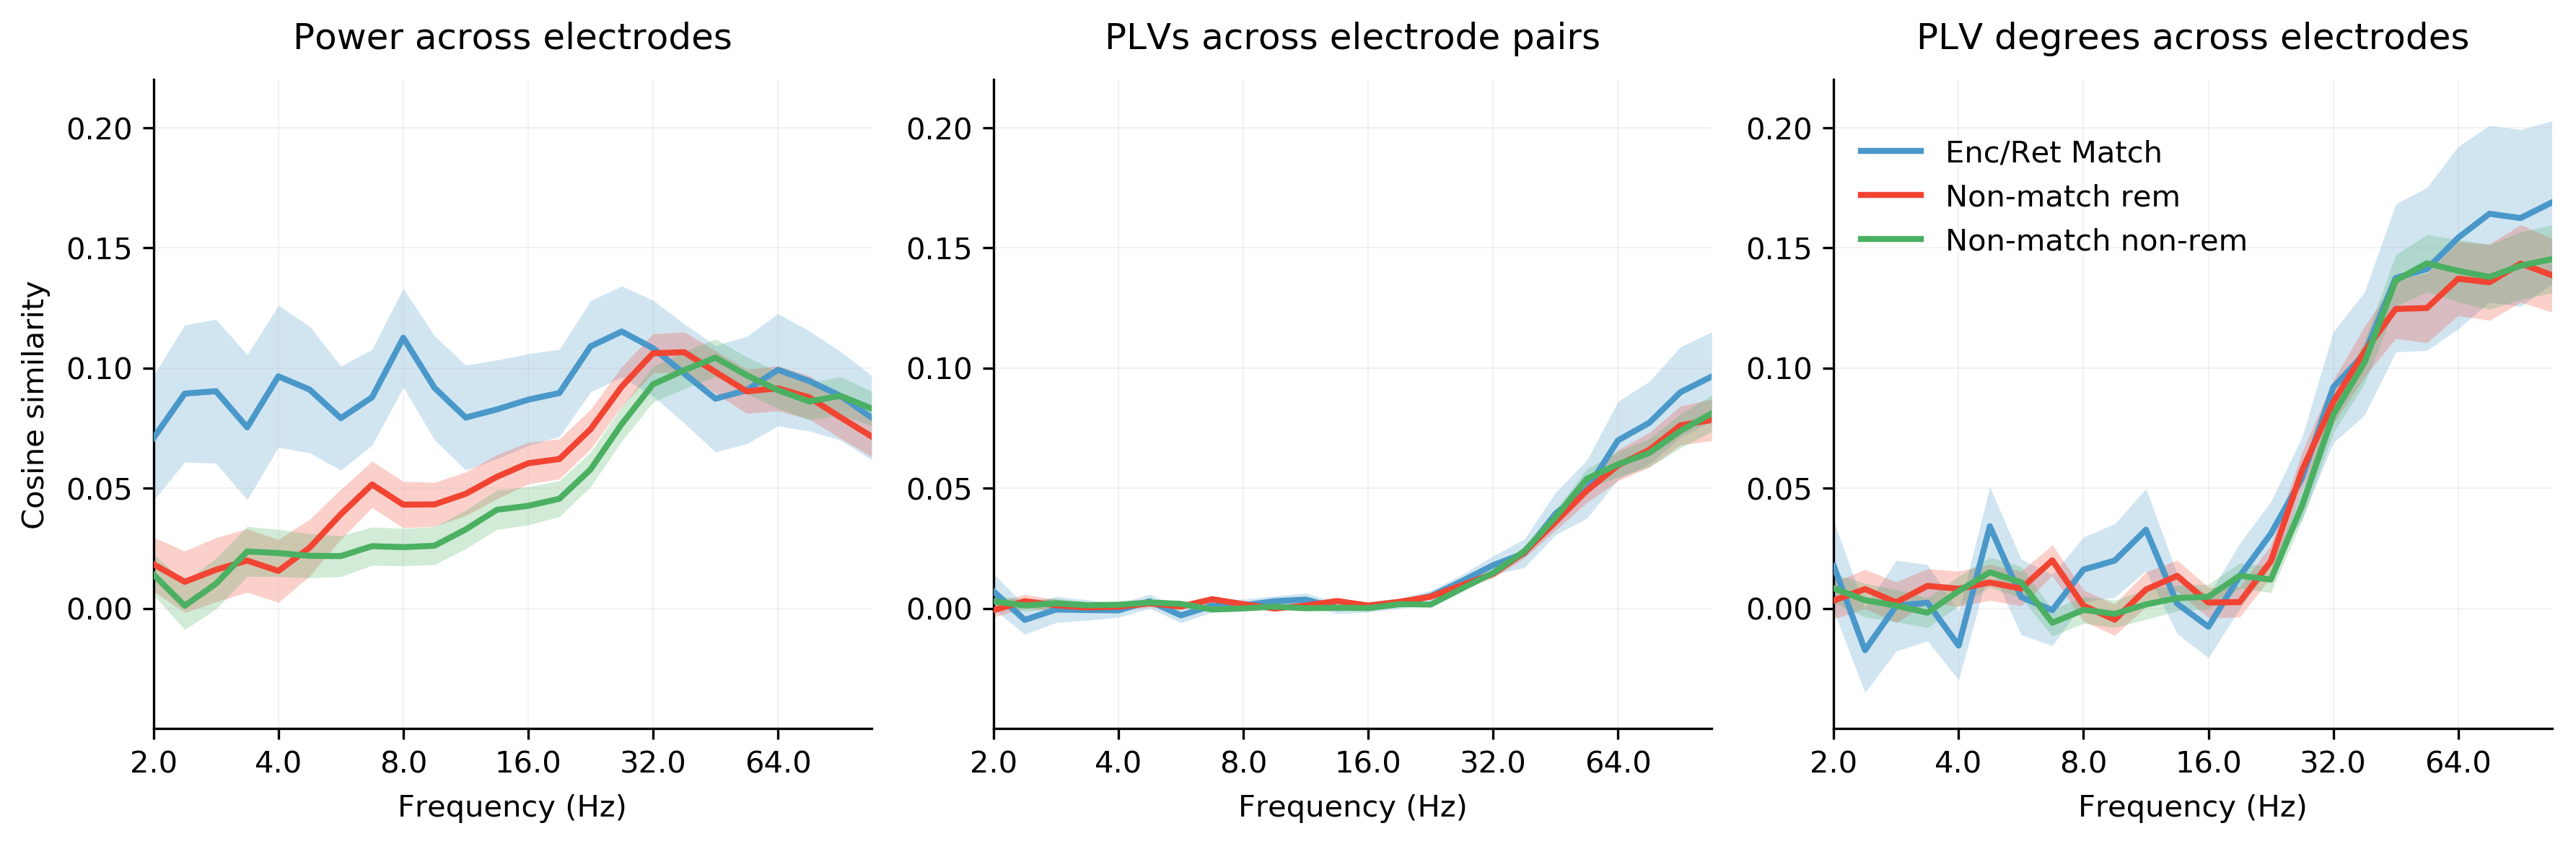

In [314]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)
tickfontsize = 10
labelfontsize = 10
figfontsize = 12

titles = {'power': 'Power across electrodes',
          'plvs': 'PLVs across electrode pairs',
          'plv_degrees': 'PLV degrees across electrodes'}
leg_labels = {'match': 'Enc/Ret Match',
              'rem': 'Non-match rem',
              'nrem': 'Non-match non-rem'}
for i in range(len(neural_types)):
    for j in range(len(bhv_types)):
        ax[i].plot(np.arange(len(freqs)), bhv_rels[neural_types[i]][bhv_types[j]]['mean'], 
                   linewidth=2, color=colors[j], zorder=3, label=leg_labels[bhv_types[j]])
        ax[i].fill_between(np.arange(len(freqs)), 
                           bhv_rels[neural_types[i]][bhv_types[j]]['mean'] + bhv_rels[neural_types[i]][bhv_types[j]]['sem'],
                           bhv_rels[neural_types[i]][bhv_types[j]]['mean'] - bhv_rels[neural_types[i]][bhv_types[j]]['sem'],
                           linewidth=0, alpha=0.25, color=colors[j], zorder=0)
    ax[i].set_title(titles[neural_types[i]], fontsize=figfontsize, y=1.02)

for i in range(len(ax)):
    ax[i].set_xlim([0, len(freqs)-1])
    ax[i].set_xticks(np.arange(len(freqs))[::4])
    ax[i].set_xticklabels(freqs[np.arange(len(freqs))[::4]], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylim([-0.05, 0.22])
    ax[i].set_yticks([0, 0.05, 0.1, 0.15, 0.2])
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('Cosine similarity', fontsize=labelfontsize, labelpad=5)
ax[-1].legend(loc=2, fontsize=10, bbox_to_anchor=[0, 0.95])
    
fig.tight_layout(w_pad=1.05)

In [403]:
len(freqs)

24

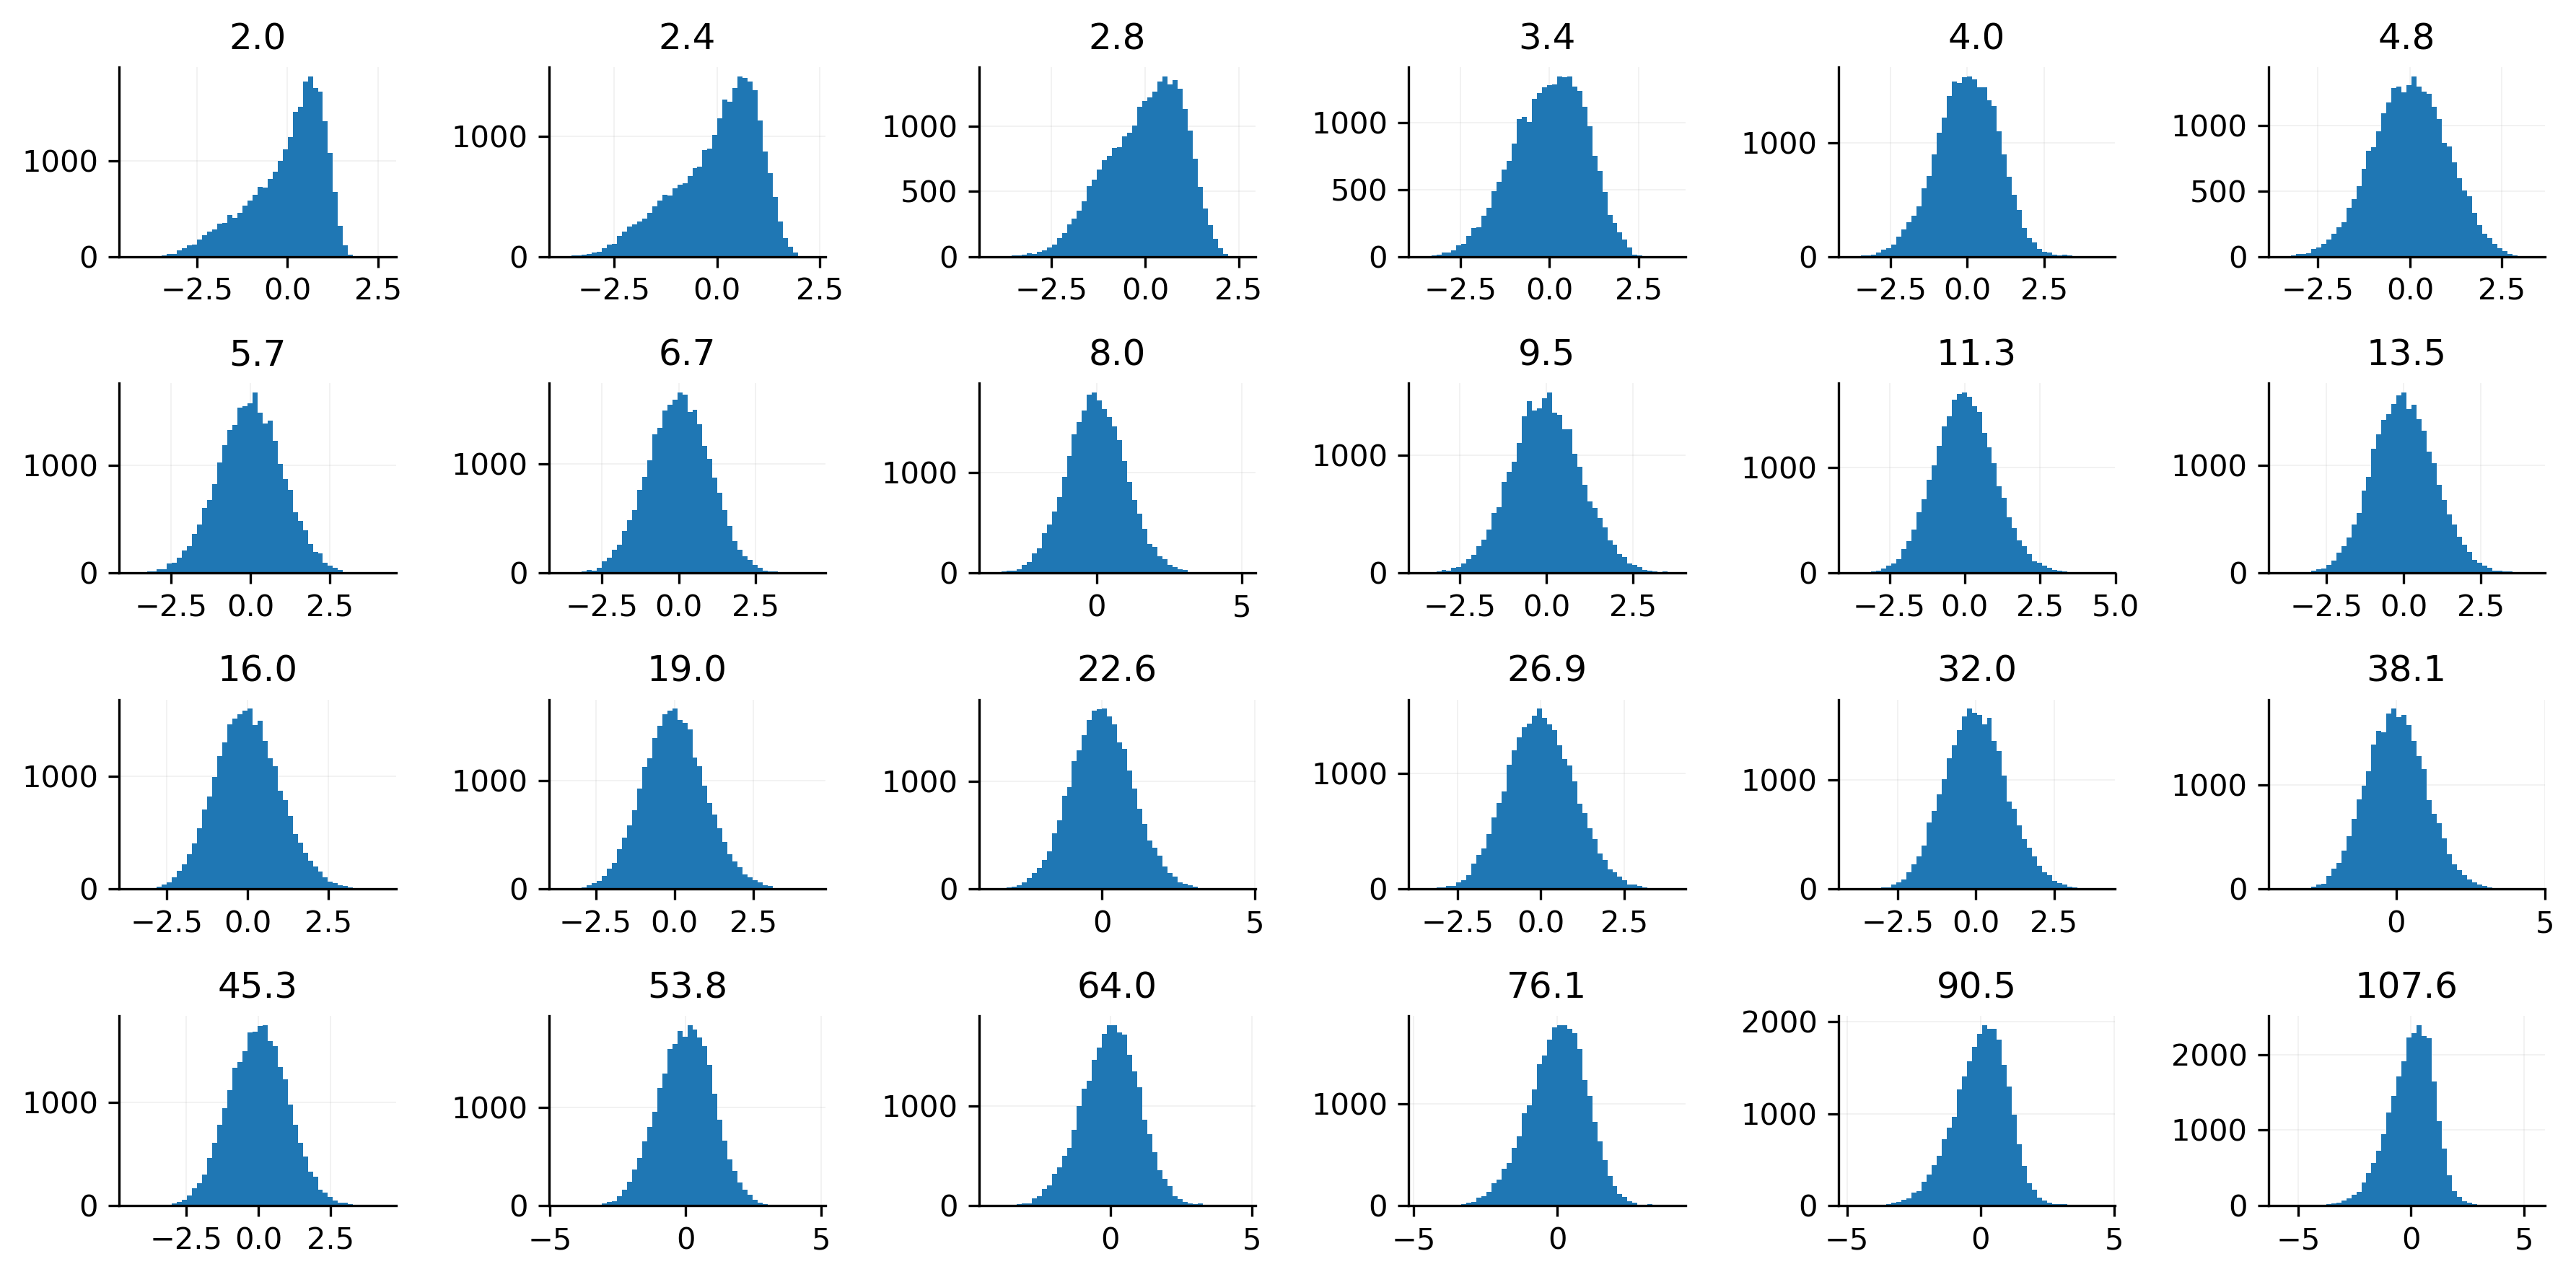

In [408]:
fig, ax = plt.subplots(4, 6, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

for i in range(24):
    ax[i].hist(neural_dat['enc']['plv_degrees'][i, :, :].flatten(), bins=50)
    ax[i].set_title(round(freqs[i], 1), y=1)
    
fig.tight_layout(w_pad=1.05, h_pad=1.05)

In [318]:
neural_dat['enc']['power'].shape, neural_dat['enc']['plvs'].shape, neural_dat['enc']['plv_degrees'].shape

((24, 288, 89), (24, 288, 3916), (24, 288, 89))

In [372]:
recalled = enc_evs.recalled.tolist()
enc_types = ['rem', 'nrem']

enc_rels = OrderedDict()
for neural_type in neural_types:
    enc_rels[neural_type] = OrderedDict()
    for enc_type in enc_types:
        mus = []
        stds = []
        sems = []
        event_inds = recalled if enc_type=='rem' else np.invert(recalled)
        for iFreq in range(len(freqs)):
            dat = np.mean(neural_dat['enc'][neural_type][iFreq, event_inds, :], axis=1) # mean across elecs
            
            mus.append(np.mean(dat))
            stds.append(np.std(dat))
            sems.append(stats.sem(dat))
        
        enc_rels[neural_type][enc_type] = {'mean': np.array(mus),
                                           'std': np.array(stds),
                                           'sem': np.array(sems)}

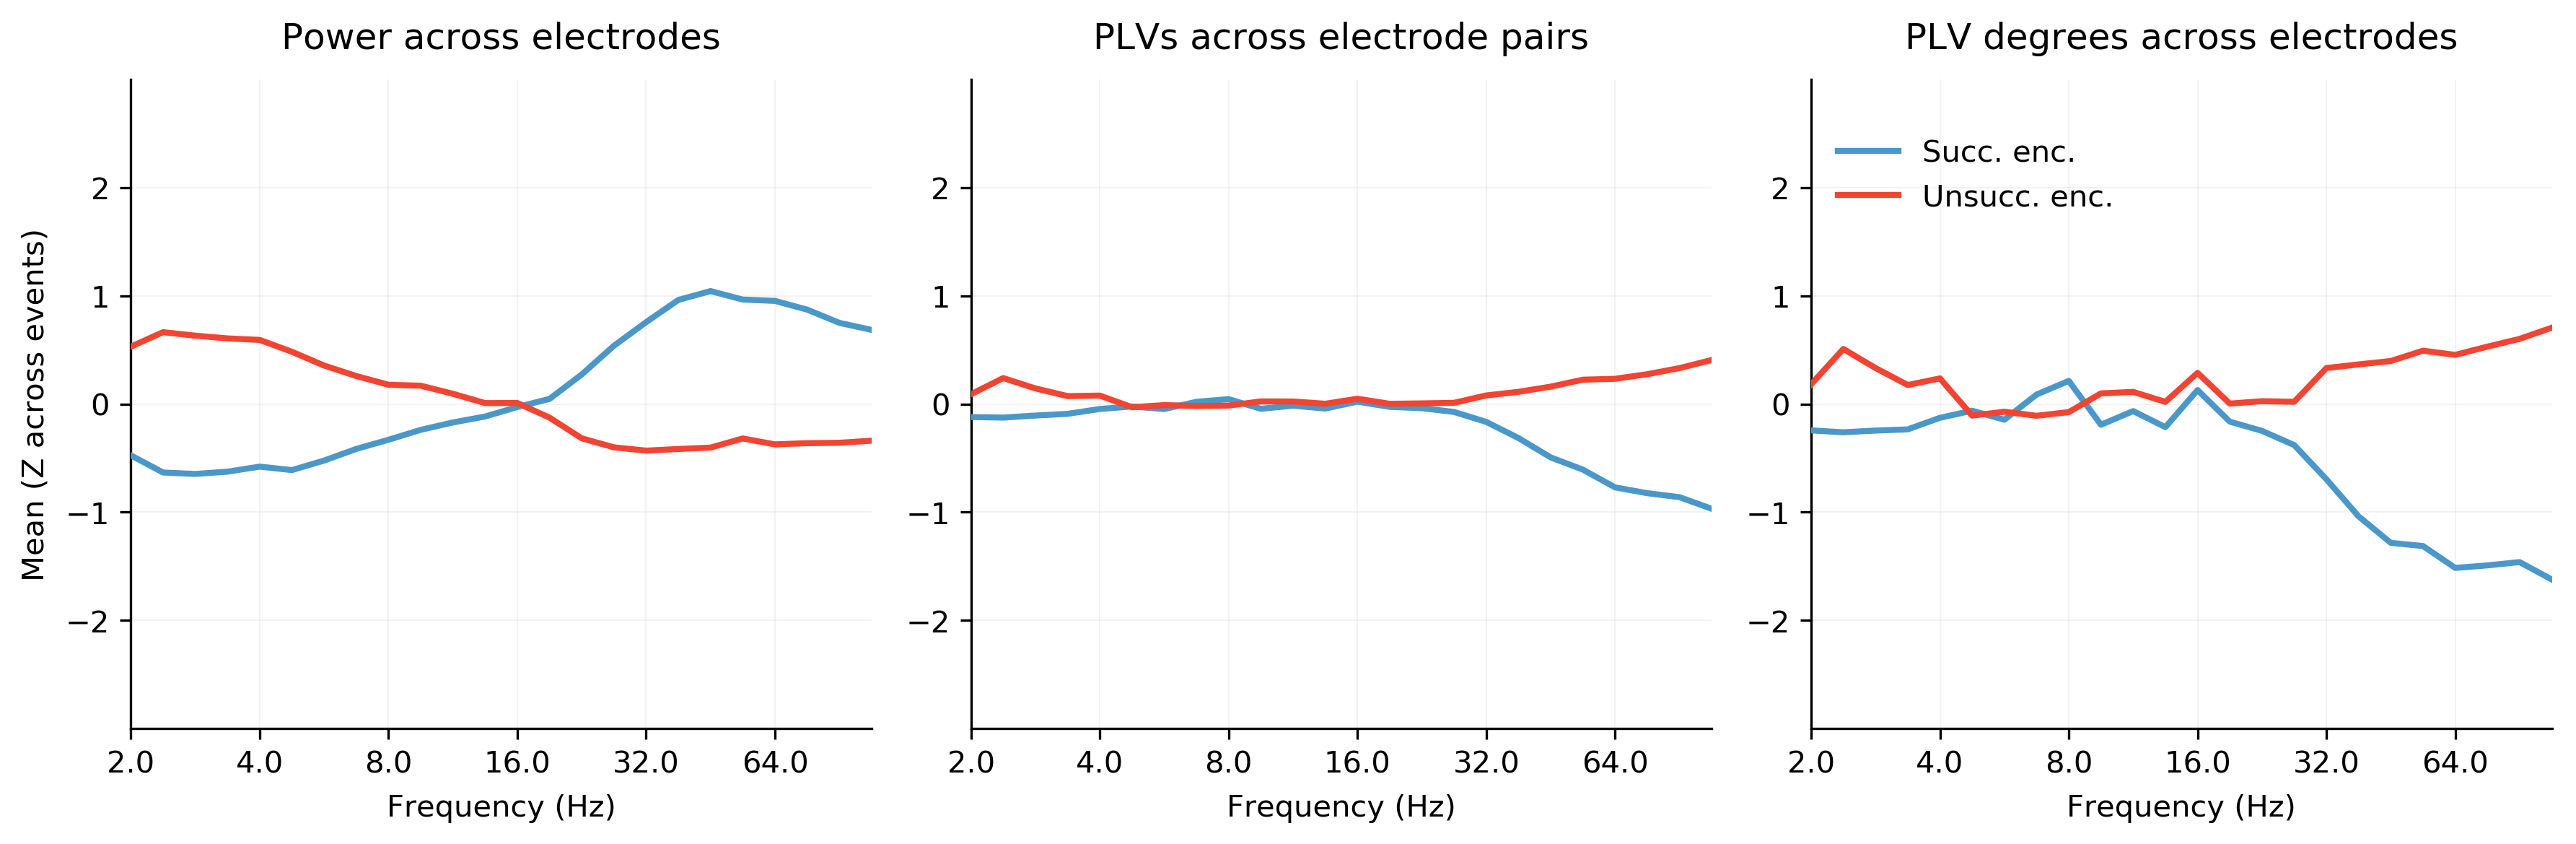

In [373]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)
tickfontsize = 10
labelfontsize = 10
figfontsize = 12

titles = {'power': 'Power across electrodes',
          'plvs': 'PLVs across electrode pairs',
          'plv_degrees': 'PLV degrees across electrodes'}
leg_labels = {'rem': 'Succ. enc.',
              'nrem': 'Unsucc. enc.'}
for i in range(len(neural_types)):
    for j in range(len(enc_types)):
        ax[i].plot(np.arange(len(freqs)), enc_rels[neural_types[i]][enc_types[j]]['mean'], 
                   linewidth=2, color=colors[j], zorder=3, label=leg_labels[enc_types[j]])
        ax[i].fill_between(np.arange(len(freqs)), 
                           enc_rels[neural_types[i]][enc_types[j]]['mean'] + enc_rels[neural_types[i]][enc_types[j]]['sem'],
                           enc_rels[neural_types[i]][enc_types[j]]['mean'] - enc_rels[neural_types[i]][enc_types[j]]['sem'],
                           linewidth=0, alpha=0.25, color=colors[j], zorder=0)
    ax[i].set_title(titles[neural_types[i]], fontsize=figfontsize, y=1.02)

for i in range(len(ax)):
    ax[i].set_xlim([0, len(freqs)-1])
    ax[i].set_xticks(np.arange(len(freqs))[::4])
    ax[i].set_xticklabels(freqs[np.arange(len(freqs))[::4]], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylim([-3, 3])
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_ylabel('')
    
ax[0].set_ylabel('Mean (Z across events)', fontsize=labelfontsize, labelpad=5)
ax[-1].legend(loc=2, fontsize=10, bbox_to_anchor=[0, 0.95])
    
fig.tight_layout(w_pad=1.05)

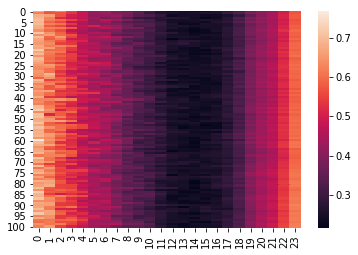

In [32]:
#sns.heatmap(plvs.reshape([plvs.shape[0], -1]))
sns.heatmap(np.mean(plvs, axis=-1))

In [15]:
lfp_synchrony.calc_plv??

Signature: lfp_synchrony.calc_plv(arr1, arr2, axis=-1)
Source:   
def calc_plv(arr1, arr2, axis=-1):
    """Return the phase-locking value(s) between two phase arrays.
    
    PLV is the mean resultant length of the circular distances between
    corresponding arr1 and arr2 elements.
    
    Parameters
    ----------
    arr1 : np.ndarray
        Phase array of any number of dimensions.
    arr2 : np.ndarray
        Phase array of equal shape as arr1.
    axis : int
        Axis to calculate the PLV over. Axis=None will calculate PLV over
        the flattened arrays and return a single number; otherwise the output
        is an array of PLVs whose shape matches the input arrays, minus the
        dimension that PLV is calculated over.
        
    Returns
    -------
    np.float64 or np.ndarray
        PLV or an array of PLVs if the input arrays have >1 dimensions 
        and axis is not None.
    """
    return circstats.circmoment(pycircstat.descriptive.cdiff(arr1, arr2), axis=a

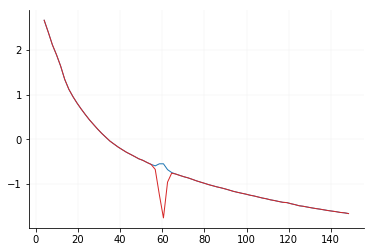

In [153]:
psds, freqs = mne.time_frequency.psd_array_welch(eeg_ret.data, sfreq=500., fmin=3, fmax=150, verbose=False)
plt.plot(freqs, np.mean(np.log10(psds), axis=(0, 1)))
psds, freqs = mne.time_frequency.psd_array_welch(eeg_ret_filt.data, sfreq=500., fmin=3, fmax=150, verbose=False)
plt.plot(freqs, np.mean(np.log10(psds), axis=(0, 1)))

In [52]:
pairs.loc[pairs['stein.region'].isin(hpc_labels), 'roi']

Series([], Name: roi, dtype: object)

In [ ]:
cmlpipe = CML_stim_pipeline.cml_pipeline(subj, expmt) 
cmlpipe.set_elecs(type='bi', flag_bad_elecs=True)
pairs = cmlpipe.elecs

if ('das.region' in pairs.columns) and not ('stein.region' in pairs.columns):
    pairs.rename(columns={'das.region', 'stein.region'}, inplace=True)
    print('Das regions!')
if 'stein.region' in pairs.columns:
    hpc_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB']
    ec_labels = ['EC', 'ERC']
    pairs['stein.region'] = pairs['stein.region'].apply(lambda x: str(x).replace('"', ''))
    pairs.loc[pairs['stein.region'].isin(hpc_labels), 'roi'] = 'hippocampal'
    pairs.loc[pairs['stein.region'].isin(ec_labels), 'roi'] = 'entorhinal'
else:
    print('missing MTL mapping!')
    
n_pairs = len(pairs)
pairs = pairs.query("(bad_elecs==False) & (roi!={})".format(['None', 'unknown'])).copy()

for sess in sessions:
    
    
    
    
    reader = CMLReader(subject=subj, 
                       experiment=expmt, 
                       session=sess, 
                       montage=mont, 
                       localization=loc)
    evs = reader.load('events')
    pairs = reader.load('pairs')
    
    # Load localization for MTL subregions
    pairs['roi'] = pairs['ind.region'].astype(str)
    pairs['hem'] = pairs['ind.x'].apply(lambda x: 'L' if x<0 else 'R')
    try:
        lclz_df = reader.load('localization')
        pairs = update_pairs(lclz_df, pairs.copy())
    except FileNotFoundError:
        print('missing localization file!')

In [38]:
update_pairs??

Signature: update_pairs(locali, info)
Source:   
def update_pairs(locali, info):
    #For recent (R1400+) subjects who have MTL info in localization file but not pairs file
    
    if 'contact_1' in info.keys(): #this is a pairs object
        pairs = info
        if 'atlases.mtl' in locali.keys():
            for atidx, i in enumerate(locali['atlases.mtl']['pairs'].index):
                mystr = i[0]+'-'+i[1]
                try:
                    row_idx = np.where(pairs['label']==mystr)[0][0]
                except:
                    continue
                pairs.loc[row_idx, 'stein.region']=locali['atlases.mtl']['pairs'][atidx]
            return pairs
        else:
            print('No MTL information found!')
            return pairs
    else:  #this is a contacts (monopolar) objects
        contacts = info
        if 'atlases.mtl' in locali.keys():
            for atidx, i in enumerate(locali['atlases.mtl']['pairs'].index):
                try:
                    row_id

In [18]:
CML_stim_pipeline??

Type:        module
String form: <module 'CML_stim_pipeline' from '/home1/esolo/notebooks/codebases/CML_stim_pipeline.py'>
File:        /home1/esolo/notebooks/codebases/CML_stim_pipeline.py
Source:     
import numpy as np
import pandas as pd
from os import mkdir
from cmlreaders import CMLReader, get_data_index
df = get_data_index("r1")

class cml_pipeline():
    
    def __init__(self, subject, experiment,):
        self.sub = subject
        self.exp = experiment
        
        
        #Get montage and localization info for this subject/experiment
        locs = df[(df['subject']==self.sub) & (df['experiment']==self.exp)]['localization'].unique()
        monts = df[(df['subject']==self.sub) & (df['experiment']==self.exp)]['montage'].unique()
        
        #Check if more than one montage/localization was used in this experiment.
        if len(locs)>1:
            print('More than one localization! Defaulting to first.')
            self.loc = locs[0]
        else:
            se

In [1446]:
# Get electrode pairs and filter out:
# 1) bipolar contacts outside of gray matter, and
# 2) bipolar contacts where either monopolar contact was in epileptiform tissue
cmlpipe = CML_stim_pipeline.cml_pipeline(subj, expmt) 
cmlpipe.set_elecs(type='bi', flag_bad_elecs=True)
pairs = cmlpipe.elecs
if not 'bad_elecs' in pairs.columns:
    print('no bad electrode file')
    pairs['bad_elecs'] = False
    pairs['electrode_categories'] = 'unknown'

print('{} electrode pairs'.format(len(pairs)))

# Load localization for MTL subregions
pairs['roi'] = pairs['ind.region'].astype(str)
pairs['hem'] = pairs['ind.x'].apply(lambda x: 'L' if x<0 else 'R')
try:
    lclz_df = reader.load('localization')
    pairs = update_pairs(lclz_df, pairs.copy())
except FileNotFoundError:
    print('missing localization file!')
    
if ('das.region' in pairs.columns) and not ('stein.region' in pairs.columns):
    pairs.rename(columns={'das.region', 'stein.region'}, inplace=True)
    print('Das regions!')
if 'stein.region' in pairs.columns:
    hpc_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB']
    ec_labels = ['EC', 'ERC']
    pairs['stein.region'] = pairs['stein.region'].apply(lambda x: str(x).replace('"', ''))
    pairs.loc[pairs['stein.region'].isin(hpc_labels), 'roi'] = 'hippocampal'
    pairs.loc[pairs['stein.region'].isin(ec_labels), 'roi'] = 'entorhinal'
else:
    print('missing MTL mapping!')
    
n_pairs = len(pairs)
pairs = pairs.query("(bad_elecs==False) & (roi!={})".format(['None', 'unknown'])).copy()

print('{}/{} electrode pairs kept after excluding bad or non-GM contacts'.format(len(pairs), n_pairs))
print(np.unique(pairs['ind.region'].astype(str), return_counts=True))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1275D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1275D/tal/R1275D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


126 electrode pairs
missing localization file!
108/126 electrode pairs kept after excluding bad or non-GM contacts
(array(['bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal',
       'insula', 'lateralorbitofrontal', 'medialorbitofrontal',
       'middletemporal', 'paracentral', 'parstriangularis', 'postcentral',
       'posteriorcingulate', 'precentral', 'rostralanteriorcingulate',
       'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal',
       'supramarginal'], dtype=object), array([ 1,  2,  6,  4,  4,  4,  5,  2,  7,  4,  6, 15,  1, 13, 21, 10,  3]))


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /data10/RAM/subjects/R1275D/docs/electrode_categories.txt
/scratch/pwanda/electrode_categories/R1275D_electrode_categories.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


In [1447]:
# Get events
events = reader.load('events')
words = events.loc[events.type.isin(['WORD', 'REC_WORD'])].copy()
words['meta_category'] = words.category.apply(catmap)

print('{} words over {} categories and {} lists, {:.1f}% recalled'
      .format(len(words.loc[words.type=='WORD']), 
              len(words.loc[words.type=='WORD'].meta_category.unique()), 
              len(words.loc[words.type=='WORD'].list.unique()), 
              100*words.loc[words.type=='WORD'].recalled.mean()))

312 words over 9 categories and 26 lists, 29.5% recalled


In [1448]:
words['include'] = 0
for meta_cat in words.meta_category.unique():
    if (len(words.query("(type=='WORD') & (meta_category=='{}')".format(meta_cat))) >= 12) and (meta_cat != 'none'):
        words.loc[words.meta_category==meta_cat, 'include'] = 1
ewords = words.loc[words.type=='WORD'].copy()
rwords = words.loc[words.type=='REC_WORD'].copy()

print('{} ({:.1f}%) of words over {} categories were included'
      .format(ewords.include.sum(), 
              100*ewords.include.mean(), 
              len(ewords.loc[ewords.include==1, 'meta_category'].unique())))

252 (80.8%) of words over 8 categories were included


In [1228]:
def catmap(x):
    """Return higher-order category mappings."""
    # not included: appliances, electronics, kitchentools, times, vehicles
    meta_d = OrderedDict([('tools', ['officesupplies', 'tools']),
                          ('leisure', ['toys', 'instruments']),
                          ('animals', ['birds', 'farmanimals', 'insects', 'zoo', 'oceananimals']),
                          ('vegetation', ['flowers', 'trees']),
                          ('human', ['clothing', 'fabric', 'materials', 'bodyparts', 'professions']),
                          ('consumption', ['beverages', 'desserts', 'fruit', 'vegetables']),
                          ('indoors', ['building', 'furniture']),
                          ('outdoors', ['landscapes', 'weather'])])
    try:
        return phase_locking.invert_dict(meta_d)[x.lower()]
    except:
        return 'none'

In [1453]:
(ewords
 .query("(meta_category!='none')")
 .groupby('meta_category')
 .agg({'item_name': [len, lambda x: len(x)/len(ewords.query("(meta_category!='none')"))]}))

item_name          
                    len  <lambda>
meta_category                    
animals              60  0.238095
consumption          48  0.190476
human                24  0.095238
indoors              24  0.095238
leisure              24  0.095238
outdoors             24  0.095238
tools                24  0.095238
vegetation           24  0.095238

In [1454]:
ewords.query("meta_category=='none'").category.unique()

array(['X', 'Appliances', 'Electronics', 'Vehicles', 'KitchenTools'],
      dtype=object)

In [1458]:
np.unique(ewords.category, return_counts=True)

(array(['Appliances', 'Beverages', 'Birds', 'BodyParts', 'Building',
        'Clothing', 'Desserts', 'Electronics', 'FarmAnimals', 'Flowers',
        'Fruit', 'Furniture', 'Insects', 'Instruments', 'KitchenTools',
        'Landscapes', 'OceanAnimals', 'OfficeSupplies', 'Tools', 'Toys',
        'Trees', 'Vegetables', 'Vehicles', 'Weather', 'X', 'Zoo'],
       dtype=object),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12]))

In [1457]:
ewords.loc[ewords.category=='Electronics', 'item_name']

129         PHONE
131      COMPUTER
137        TABLET
139         RADIO
182       SPEAKER
184     MICROWAVE
194    TELEVISION
196    HEADPHONES
448       SCANNER
450       PRINTER
456        STEREO
458    CALCULATOR
Name: item_name, dtype: object

In [1464]:
#ewords.eegoffset.diff()
ewords.columns

Index(['eegoffset', 'answer', 'category', 'category_num', 'eegfile',
       'exp_version', 'experiment', 'intrusion', 'is_stim', 'iscorrect',
       'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime',
       'phase', 'protocol', 'recalled', 'recog_resp', 'recog_rt', 'recognized',
       'rectime', 'rejected', 'serialpos', 'session', 'stim_list',
       'stim_params', 'subject', 'test', 'type', 'meta_category', 'include'],
      dtype='object')

In [1473]:
np.diff(ewords.eegoffset).min() - 1000

1381

In [1491]:
# Get EEG
buffer = 1500 # to remove edge effects during wavelet convolution
eeg = reader.load_eeg(events=ewords, rel_start=-200-buffer, rel_stop=1200+buffer, scheme=pairs)
eeg_ptsa = eeg.to_ptsa()
eeg_mne = eeg.to_mne()

312 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [1499]:
for freq_range in [[58., 62.], [118., 122.]]:
    print(freq_range)

[58.0, 62.0]
[118.0, 122.0]


In [ ]:
freqs = np.array([2**((3+i)/3) for i in range(20)])

start_time = time()
sampling_rate = eeg_mne.info['sfreq']

# Remove line noise
proc_eeg = eeg_ptsa.copy()
for freq_range in [[58., 62.], [118., 122.]]:
    proc_eeg = ButterworthFilter(timeseries=proc_eeg, freq_range=freq_range, filt_type='stop', order=4).filter()

#Get spectral power and phase
power, phase = MorletWaveletFilter(timeseries=proc_eeg, freqs=freqs, width=5, output=['power', 'phase']).filter()

print('Done in {:.2f} secs'.format(time() - start_time))

In [ ]:
#powerdat = power.data[:, :, :, int((buffer/1000)*sampling_rate):-1*int((buffer/1000)*sampling_rate)]  # remove buffer period
#pows = np.log10(pows)   #take log of powers

In [ ]:
start_ind = events.loc[events.type=='SESS_START'].eegoffset.iat[0]
events['sec'] = (events.eegoffset - start_ind) / eeg.samplerate
events.shape, events.columns

(array(['entorhinal', 'fusiform', 'inferiorparietal', 'inferiortemporal',
        'insula', 'lateralorbitofrontal', 'medialorbitofrontal',
        'middletemporal', 'parahippocampal', 'parsorbitalis',
        'parstriangularis', 'rostralanteriorcingulate',
        'rostralmiddlefrontal', 'superiortemporal', 'temporalpole'],
       dtype=object),
 array([ 6,  2,  1, 12,  8, 11,  3, 15,  1,  3,  1,  3,  8,  6,  2]))

In [1097]:
#CML_stim_pipeline??

In [1101]:
#CMLReader.readers

In [410]:
#CMLReader??

In [1104]:
reader = CMLReader(subject=subj, 
                   experiment=expmt, 
                   session=sessions[0],
                   localization=lclz, 
                   montage=mont)
lclz_df = reader.load('localization')
pairs = reader.load('pairs')

In [1103]:
pairs[['contact_1', 'contact_2', 'label']].head()

,contact_1,contact_2,label
0,1,2,RB1-RB2
1,2,3,RB2-RB3
2,3,4,RB3-RB7
3,4,5,RB7-RB8
4,5,6,RB8-RB9


In [1105]:
lclz_df['atlases.mtl']['pairs'].dropna()

(LB3, LB4)    "sulcus"
(LC1, LC2)       "PHC"
(LC2, LC3)       "PHC"
(RB2, RB3)      "BA36"
(RB4, RB5)      "BA36"
Name: atlases.mtl, dtype: object

In [397]:
pairs[['contact_1', 'contact_2', 'label']].loc[pairs.label=='LC3-LC4']

,contact_1,contact_2,label


In [413]:
eeg = reader.load('eeg')

In [1106]:
#eeg.channels

In [1107]:
#reader.readers['eeg']

In [1108]:
#reader._construct_reader??

In [371]:
pairs.loc[pairs.bad_elecs==True]
pairs.loc[pairs.label=='LC3-LC4']

,contact_1,contact_2,label,avg.corrected.region,avg.corrected.x,avg.corrected.y,avg.corrected.z,avg.region,avg.x,avg.y,...,type_1,type_2,vox.region,vox.x,vox.y,vox.z,bad_elecs,electrode_categories,roi,hem


In [364]:
bad_contacts

['LB1-LB2',
 'LB2-LB3',
 'LB3-LB4',
 'LB9-LB10',
 'LB10-LB1',
 'LC1-LC2',
 'LC2-LC3',
 'LC3-LC7',
 'LC7-LC10',
 'LC10-LC1',
 'RB1-RB2',
 'RB2-RB4',
 'RB9-RB1',
 'RC1-RC2',
 'RC2-RC7',
 'RC9-RC1',
 'RQ5-RQ7',
 'RQ7-RQ8',
 'RQ8-RQ9',
 'RQ9-RQ1',
 'RO7-RO8',
 'RO8-RO9',
 'RO9-RO1']

In [365]:
np.unique(pairs['stein.region'], return_counts=True)

(array(['None', 'nan'], dtype=object), array([ 3, 62]))

In [297]:
# Where are our contacts?
np.unique(pairs.roi, return_counts=True)

(array(['caudalanteriorcingulate', 'caudalmiddlefrontal', 'entorhinal',
        'inferiorparietal', 'inferiortemporal', 'insula',
        'lateralorbitofrontal', 'lingual', 'medialorbitofrontal',
        'middletemporal', 'parsorbitalis', 'parstriangularis',
        'postcentral', 'posteriorcingulate', 'precentral', 'precuneus',
        'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal',
        'supramarginal', 'temporalpole'], dtype=object),
 array([1, 4, 4, 1, 4, 8, 5, 3, 3, 6, 2, 1, 1, 2, 3, 3, 3, 7, 1, 2, 1]))

In [270]:
pairs.columns

Index(['contact_1', 'contact_2', 'label', 'avg.corrected.region',
       'avg.corrected.x', 'avg.corrected.y', 'avg.corrected.z', 'avg.region',
       'avg.x', 'avg.y', 'avg.z', 'hcp.region', 'hcp.x', 'hcp.y', 'hcp.z',
       'ind.corrected.region', 'ind.corrected.x', 'ind.corrected.y',
       'ind.corrected.z', 'ind.region', 'ind.x', 'ind.y', 'ind.z',
       'is_stim_only', 'mni.region', 'mni.x', 'mni.y', 'mni.z', 'stein.region',
       'stein.x', 'stein.y', 'stein.z', 'type_1', 'type_2', 'vox.region',
       'vox.x', 'vox.y', 'vox.z', 'bad_elecs', 'electrode_categories', 'roi'],
      dtype='object')

In [360]:
pairs['roi'].unique()

array(['middletemporal', 'insula', 'entorhinal', 'lingual',
       'inferiortemporal', 'precuneus', 'superiorparietal',
       'supramarginal', 'inferiorparietal', 'superiorfrontal',
       'caudalmiddlefrontal', 'posteriorcingulate', 'precentral',
       'rostralmiddlefrontal', 'postcentral', 'temporalpole',
       'caudalanteriorcingulate', 'medialorbitofrontal',
       'lateralorbitofrontal', 'parstriangularis', 'parsorbitalis'],
      dtype=object)

In [347]:
pairs.label.tolist()[:10]

['LB8-LB9',
 'LA2-LA3',
 'LA3-LA4',
 'LA4-LA5',
 'LA5-LA6',
 'LI2-LI3',
 'LI3-LI4',
 'LI4-LI5',
 'LV1-LV2',
 'LV2-LV3']

In [348]:
lclz_df['atlases.mtl']['pairs']

(LA1, LA2)        NaN
(LA2, LA3)        NaN
(LA3, LA4)        NaN
(LA4, LA5)        NaN
(LA5, LA6)        NaN
(LA6, LA7)        NaN
(LA7, LA8)        NaN
(LA8, LA9)        NaN
(LA10, LA9)       NaN
(LB1, LB2)       "DG"
(LB2, LB3)       "DG"
(LB3, LB4)        NaN
(LB4, LB5)        NaN
(LB5, LB6)        NaN
(LB6, LB7)        NaN
(LB7, LB8)        NaN
(LB8, LB9)        NaN
(LB10, LB9)       NaN
(LC1, LC2)      "CA1"
(LC2, LC3)       "DG"
(LC3, LC4)      "CA1"
(LC4, LC5)        NaN
(LC5, LC6)        NaN
(LC6, LC7)        NaN
(LC7, LC8)        NaN
(LC8, LC9)        NaN
(LC10, LC9)       NaN
(LI1, LI2)        NaN
(LI2, LI3)        NaN
(LI3, LI4)        NaN
                ...  
(RM11, RM12)      NaN
(RM12, RM13)      NaN
(RM13, RM14)      NaN
(RO1, RO2)        NaN
(RO2, RO3)        NaN
(RO3, RO4)        NaN
(RO4, RO5)        NaN
(RO5, RO6)        NaN
(RO6, RO7)        NaN
(RO7, RO8)        NaN
(RO8, RO9)        NaN
(RO10, RO9)       NaN
(RQ1, RQ2)        NaN
(RQ2, RQ3)        NaN
(RQ3, RQ4)

In [230]:
update_pairs??

Signature: update_pairs(locali, info)
Source:   
def update_pairs(locali, info):
    #For recent (R1400+) subjects who have MTL info in localization file but not pairs file
    
    if 'contact_1' in info.keys(): #this is a pairs object
        pairs = info
        if 'atlases.mtl' in locali.keys():
            for atidx, i in enumerate(locali['atlases.mtl']['pairs'].index):
                mystr = i[0]+'-'+i[1]
                try:
                    row_idx = np.where(pairs['label']==mystr)[0][0]
                except:
                    continue
                pairs.loc[row_idx, 'stein.region']=locali['atlases.mtl']['pairs'][atidx]
            return pairs
        else:
            print('No MTL information found!')
            return pairs
    else:  #this is a contacts (monopolar) objects
        contacts = info
        if 'atlases.mtl' in locali.keys():
            for atidx, i in enumerate(locali['atlases.mtl']['pairs'].index):
                try:
                    row_id

In [225]:
np.sum(pairs['stein.region']=='CA1')

0

In [217]:
if ('stein.region' in pairs_.keys()) and (len(pairs_['stein.region'].unique())>1):
    print('meow')

meow


In [211]:
pairs.shape, pairs_.shape

((177, 40), (167, 41))

In [183]:
pairs['stein.region'].unique(), pairs_['stein.region'].unique()

(array(['"CA1"', nan, '"BA36"', None], dtype=object),
 array(['"CA1"', nan, '"BA36"', None], dtype=object))

In [184]:
get_region(pairs, region='hipp')

,contact_1,contact_2,label,avg.corrected.region,avg.corrected.x,avg.corrected.y,avg.corrected.z,avg.region,avg.x,avg.y,...,stein.y,stein.z,type_1,type_2,vox.region,vox.x,vox.y,vox.z,bad_elecs,electrode_categories
0,1,2,LB1-LB2,None,-28.341418,-14.901365,-22.620384,None,-28.341418,-14.901365,...,None,None,D,D,None,306.0,255.0,95.0,True,interictal
40,41,42,LC1-LC2,None,-38.180145,-31.627899,-12.693926,None,-38.180145,-31.627899,...,None,None,D,D,None,311.0,286.0,99.0,False,
41,42,43,LC2-LC3,None,-39.205585,-26.705654,-19.128400,None,-39.205585,-26.705654,...,None,None,D,D,None,317.0,286.0,99.0,False,


In [307]:
pairs.columns

Index(['contact_1', 'contact_2', 'label', 'avg.corrected.region',
       'avg.corrected.x', 'avg.corrected.y', 'avg.corrected.z', 'avg.region',
       'avg.x', 'avg.y', 'avg.z', 'hcp.region', 'hcp.x', 'hcp.y', 'hcp.z',
       'ind.corrected.region', 'ind.corrected.x', 'ind.corrected.y',
       'ind.corrected.z', 'ind.region', 'ind.x', 'ind.y', 'ind.z',
       'is_stim_only', 'mni.region', 'mni.x', 'mni.y', 'mni.z', 'stein.region',
       'stein.x', 'stein.y', 'stein.z', 'type_1', 'type_2', 'vox.region',
       'vox.x', 'vox.y', 'vox.z', 'bad_elecs', 'electrode_categories', 'roi'],
      dtype='object')

In [310]:
pairs.head()

,contact_1,contact_2,label,avg.corrected.region,avg.corrected.x,avg.corrected.y,avg.corrected.z,avg.region,avg.x,avg.y,...,stein.z,type_1,type_2,vox.region,vox.x,vox.y,vox.z,bad_elecs,electrode_categories,roi
4,5,6,LB8-LB9,None,-53.002096,-6.511369,-22.203168,None,-53.002096,-6.511369,...,None,D,D,None,356.0,240.0,143.0,False,,middletemporal
7,8,9,LA2-LA3,None,-19.349466,-5.894621,-29.458764,None,-19.349466,-5.894621,...,None,D,D,None,291.0,232.0,146.0,False,,insula
8,9,10,LA3-LA4,None,-20.145808,-3.157870,-27.240718,None,-20.145808,-3.157870,...,None,D,D,None,299.0,230.0,146.0,False,,insula
9,10,11,LA4-LA5,None,-23.255366,-1.836758,-23.444872,None,-23.255366,-1.836758,...,None,D,D,None,306.0,229.0,147.0,False,,insula
10,11,12,LA5-LA6,None,-27.451482,-2.355726,-21.589684,None,-27.451482,-2.355726,...,None,D,D,None,313.0,228.0,147.0,False,,insula


In [306]:
pairs['ind.x']<0

4       True
7       True
8       True
9       True
10      True
14      True
15      True
16      True
25      True
26      True
27      True
29      True
30      True
32      True
33      True
35      True
38      True
40      True
41      True
43      True
44      True
46      True
47      True
48      True
49      True
51      True
52      True
53      True
54      True
56      True
       ...  
65      True
67      True
68     False
69     False
71     False
74     False
79     False
80     False
81     False
85     False
86     False
88     False
90     False
92     False
94      True
100    False
101    False
102    False
103    False
104    False
105    False
110     True
112     True
113     True
115     True
116     True
118    False
119    False
120    False
122    False
Name: ind.x, Length: 65, dtype: bool

In [133]:
get_region??

Signature: get_region(loc, region=None, side=None)
Source:   
def get_region(loc, region=None, side=None):
    #Return datastructure of specified region or MTL subfield
    #'MTL' is a special region label that gets hipp/entorhinal/parahippocampal cortices, 'hipp' gets all hippocampal subfields, and 'phg' gets parahippocampal gyrus
    
    MTL_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB', 'EC', 'PRC', 'PHC', 'BA35', 'BA36', 'ERC']
    hipp_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB']
    phg_labels = ['PHC', 'EC', 'PRC', 'BA35', 'BA36', 'ERC']
    EC_labels = ['EC', 'ERC']
    PRC_labels = ['PRC', 'BA35', 'BA36']
    
    if side is None:
        side_arr = np.ones(len(loc)).astype(bool)
    elif side=='left':
        side_arr = np.zeros(len(loc)).astype(bool)
        side_arr[np.array(loc['ind.x']<0).astype(bool)] = True
    elif side=='right':
        side_arr = np.zeros(len(loc)).astype(bool)
        side_arr[np.array(loc['ind.x']>0).astype(bool)] = True
    else:
      

In [131]:
np.unique(pairs['stein.region'])

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

(array(['caudalmiddlefrontal', 'cuneus', 'entorhinal', 'fusiform',
        'inferiorparietal', 'inferiortemporal', 'insula',
        'isthmuscingulate', 'lateraloccipital', 'middletemporal',
        'paracentral', 'parahippocampal', 'postcentral', 'precentral',
        'precuneus', 'superiorparietal', 'superiortemporal',
        'supramarginal', 'temporalpole'], dtype=object),
 array([ 1,  3,  2,  6, 25,  5,  7,  5,  2, 14,  3,  1,  7, 14, 24, 16,  3,
        16,  4]))

In [92]:
pairs.query("(ind_region=='None')")

,contact_1,contact_2,label,avg.dural.region,avg.dural.x,avg.dural.y,avg.dural.z,avg.region,avg.x,avg.y,...,type_2,wb.region,wb.x,wb.y,wb.z,mni.x,mni.y,mni.z,bad_elecs,electrode_categories
38,43,44,A1-A2,None,-17.730,-8.840,-22.115,None,-17.730,-8.840,...,D,Left Ent entorhinal area,None,None,None,-18.97590,1.963640,-26.429244,True,soz
39,44,45,A2-A3,None,-22.565,-8.725,-22.190,None,-22.565,-8.725,...,D,Left Amygdala,None,None,None,-22.67170,2.359905,-26.644984,True,soz
40,45,46,A3-A4,None,-28.555,-8.580,-22.285,None,-28.555,-8.580,...,D,Left Amygdala,None,None,None,-27.66355,3.227180,-27.068020,False,
41,46,47,A4-A5,None,-34.085,-8.445,-22.375,None,-34.085,-8.445,...,D,Left Cerebral White Matter,None,None,None,-33.19750,3.849300,-27.772326,False,
45,51,52,HH1-HH2,None,-26.700,-16.130,-21.485,None,-26.700,-16.130,...,D,Left Hippocampus,None,None,None,-25.94395,-4.711905,-26.093993,True,interictal
46,52,53,HH2-HH3,None,-31.090,-16.635,-21.775,None,-31.090,-16.635,...,D,Left Hippocampus,None,None,None,-29.74820,-5.038275,-28.322125,True,interictal
47,53,54,HH3-HH4,fusiform,-37.310,-16.930,-22.610,fusiform,-37.310,-16.930,...,D,Left Cerebral White Matter,None,None,None,-35.63855,-6.334400,-31.221702,False,
52,59,60,HB1-HB2,None,-22.565,-21.655,-15.880,None,-22.565,-21.655,...,D,Left Hippocampus,None,None,None,-23.29555,-11.637800,-18.516098,True,interictal
53,60,61,HB2-HB3,None,-26.490,-21.730,-15.425,None,-26.490,-21.730,...,D,Left Hippocampus,None,None,None,-27.23170,-11.048600,-19.298596,True,interictal
54,61,62,HB3-HB4,None,-30.185,-21.810,-14.970,None,-30.185,-21.810,...,D,Left Hippocampus,None,None,None,-31.02680,-10.540800,-20.459255,True,interictal


In [71]:
#pairs.electrode_categories

In [61]:
np.unique(pairs['ind.region'].astype(str), return_counts=True)

(array(['None', 'fusiform', 'inferiortemporal', 'insula',
        'lateraloccipital', 'lateralorbitofrontal', 'lingual',
        'medialorbitofrontal', 'middletemporal', 'parahippocampal',
        'parstriangularis', 'postcentral', 'precentral',
        'superiortemporal', 'transversetemporal'], dtype=object),
 array([14, 11,  9,  6,  4,  6, 11,  3,  8,  4,  4,  7,  4,  7,  4]))

In [107]:
try:
    cmlpipe.reader.load('electrode_categories')
except FileNotFoundError:
    print(':(')

:(


In [65]:
#cmlpipe.elecs
cmlpipe.reader.load('electrode_categories')

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /data10/RAM/subjects/R1123C/docs/electrode_categories.txt
/scratch/pwanda/electrode_categories/electrode_categories_R1123C.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


{'soz': ['A1',
  'A2',
  'BT2',
  'BT3',
  'BT4',
  'BT5',
  'BT9',
  'HB1',
  'HB2',
  'HB3',
  'HB4',
  'HH1',
  'HH2'],
 'interictal': ['BT2',
  'BT3',
  'BT4',
  'BT5',
  'BT9',
  'HB1',
  'HB2',
  'HB3',
  'HB4',
  'HH1',
  'HH2'],
 'bad_channel': [],
 'brain_lesion': []}

In [31]:
cmlpipe.set_elecs??

Signature: cmlpipe.set_elecs(type='bi', flag_bad_elecs=True)
Source:   
    def set_elecs(self, type='bi', flag_bad_elecs=True):
        #Load electrode information. Use 'bi' for bipolar pairs or 'mono' for unrereferenced monopolars
        
        reader = self.reader
        if type=='bi':
            self.elecs = reader.load('pairs')
        elif type=='mono':
            self.elecs = reader.load('contacts')
        else:
            raise ValueError('Please specify either "bi" or "mono" for electrode type.')
        
        #For removing electrodes in electrode_categories.txt
        if flag_bad_elecs:
            try:
                elec_cat = reader.load('electrode_categories')
            except:
                print('No electrode categories file found!')
                return
            
            cat_names = np.array(['' for i in range(len(self.elecs))]).astype('U20')
            cat_bool = np.zeros(len(self.elecs)).astype(bool)
            
            #Find the conta

## word2vec

In [431]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def cos_sim2(v1, v2):
    """Return the cosine similarity between v1 and v2."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [634]:
# Get a list of all FR1 words.
start_time = time()

import warnings
warnings.filterwarnings('ignore')
m = np.array([r1_df.loc[r1_df.experiment=='FR1'].subject.tolist(),
              r1_df.loc[r1_df.experiment=='FR1'].session.tolist()])
fr1_words = []
for i in range(m.shape[1]):
    subj = m[0, i]
    sess = m[1, i]
    reader = CMLReader(subj, 'FR1', sess)
    events = reader.load('events')
    new_words = events.loc[events.type=='WORD'].item_name.tolist()
    fr1_words += new_words
    if i > 10:
        break
fr1_words = list(np.unique(fr1_words))
print('Found {} unique words'.format(len(fr1_words)))
warnings.filterwarnings('default')

print('Done in {:.2f} secs'.format(time() - start_time))

Found 300 unique words
Done in 0.56 secs


In [433]:
# Load Google's pre-trained Word2Vec model.
d = '/scratch/dscho/category_connectivity/data/word2vec'
f = os.path.join(d, 'GoogleNews-vectors-negative300.bin')
model = gensim.models.KeyedVectors.load_word2vec_format(f, binary=True)

In [637]:
word_vecs = OrderedDict()
count = 0
for word in fr1_words:
    try:
        word_vecs[word] = model.get_vector(word)
    except KeyError:
        count += 1
print(count)

0


In [638]:
d = '/scratch/dscho/category_connectivity/data/word2vec'
dio.save_pickle(word_vecs, os.path.join(d, 'fr1_word_vecs.pkl'))

Saved /scratch/dscho/category_connectivity/data/word2vec/fr1_word_vecs.pkl


In [639]:
word_vecs.keys()

odict_keys(['ANT', 'APE', 'ARK', 'ARM', 'AXE', 'BADGE', 'BAG', 'BALL', 'BAND', 'BANK', 'BARN', 'BAT', 'BATH', 'BEACH', 'BEAK', 'BEAN', 'BEAR', 'BED', 'BEE', 'BENCH', 'BIRD', 'BLOOM', 'BLUSH', 'BOARD', 'BOAT', 'BOMB', 'BOOK', 'BOOT', 'BOWL', 'BOX', 'BOY', 'BRANCH', 'BREAD', 'BRICK', 'BRIDGE', 'BROOM', 'BRUSH', 'BUSH', 'CAGE', 'CAKE', 'CALF', 'CANE', 'CAPE', 'CAR', 'CART', 'CASH', 'CAT', 'CAVE', 'CHAIR', 'CHALK', 'CHEEK', 'CHIEF', 'CHIN', 'CLAY', 'CLIFF', 'CLOCK', 'CLOTH', 'CLOUD', 'CLOWN', 'COIN', 'CONE', 'CORD', 'CORN', 'COUCH', 'COW', 'CRANE', 'CROW', 'CROWN', 'CUBE', 'CUP', 'DART', 'DEER', 'DESK', 'DIME', 'DITCH', 'DOCK', 'DOG', 'DOLL', 'DOOR', 'DRESS', 'DRUM', 'DUCK', 'EAR', 'EEL', 'EGG', 'ELF', 'FACE', 'FAN', 'FARM', 'FENCE', 'FILM', 'FISH', 'FLAG', 'FLAME', 'FLEA', 'FLOOR', 'FLUTE', 'FOAM', 'FOG', 'FOOD', 'FOOT', 'FORK', 'FORT', 'FOX', 'FROG', 'FRUIT', 'FUDGE', 'FUR', 'GATE', 'GEESE', 'GLASS', 'GLOVE', 'GOAT', 'GOLD', 'GRAPE', 'GRASS', 'GUARD', 'HAND', 'HAT', 'HAWK', 'HEART', 'HEN

In [1087]:
#pca = PCA(n_components=6)
pca = PCA(n_components=6)
word_pcs = pca.fit_transform(np.array([word_vecs[word] for word in list(word_vecs.keys())]))
word_pcs = pd.DataFrame(word_pcs, index=list(word_vecs.keys()), columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']).reset_index()
word_pcs.rename(columns={'index': 'word'}, inplace=True)
print(word_pcs.shape, pca.explained_variance_ratio_)

(300, 7) [0.0630621  0.02254077 0.02002982 0.01887053 0.01753022 0.01724116]


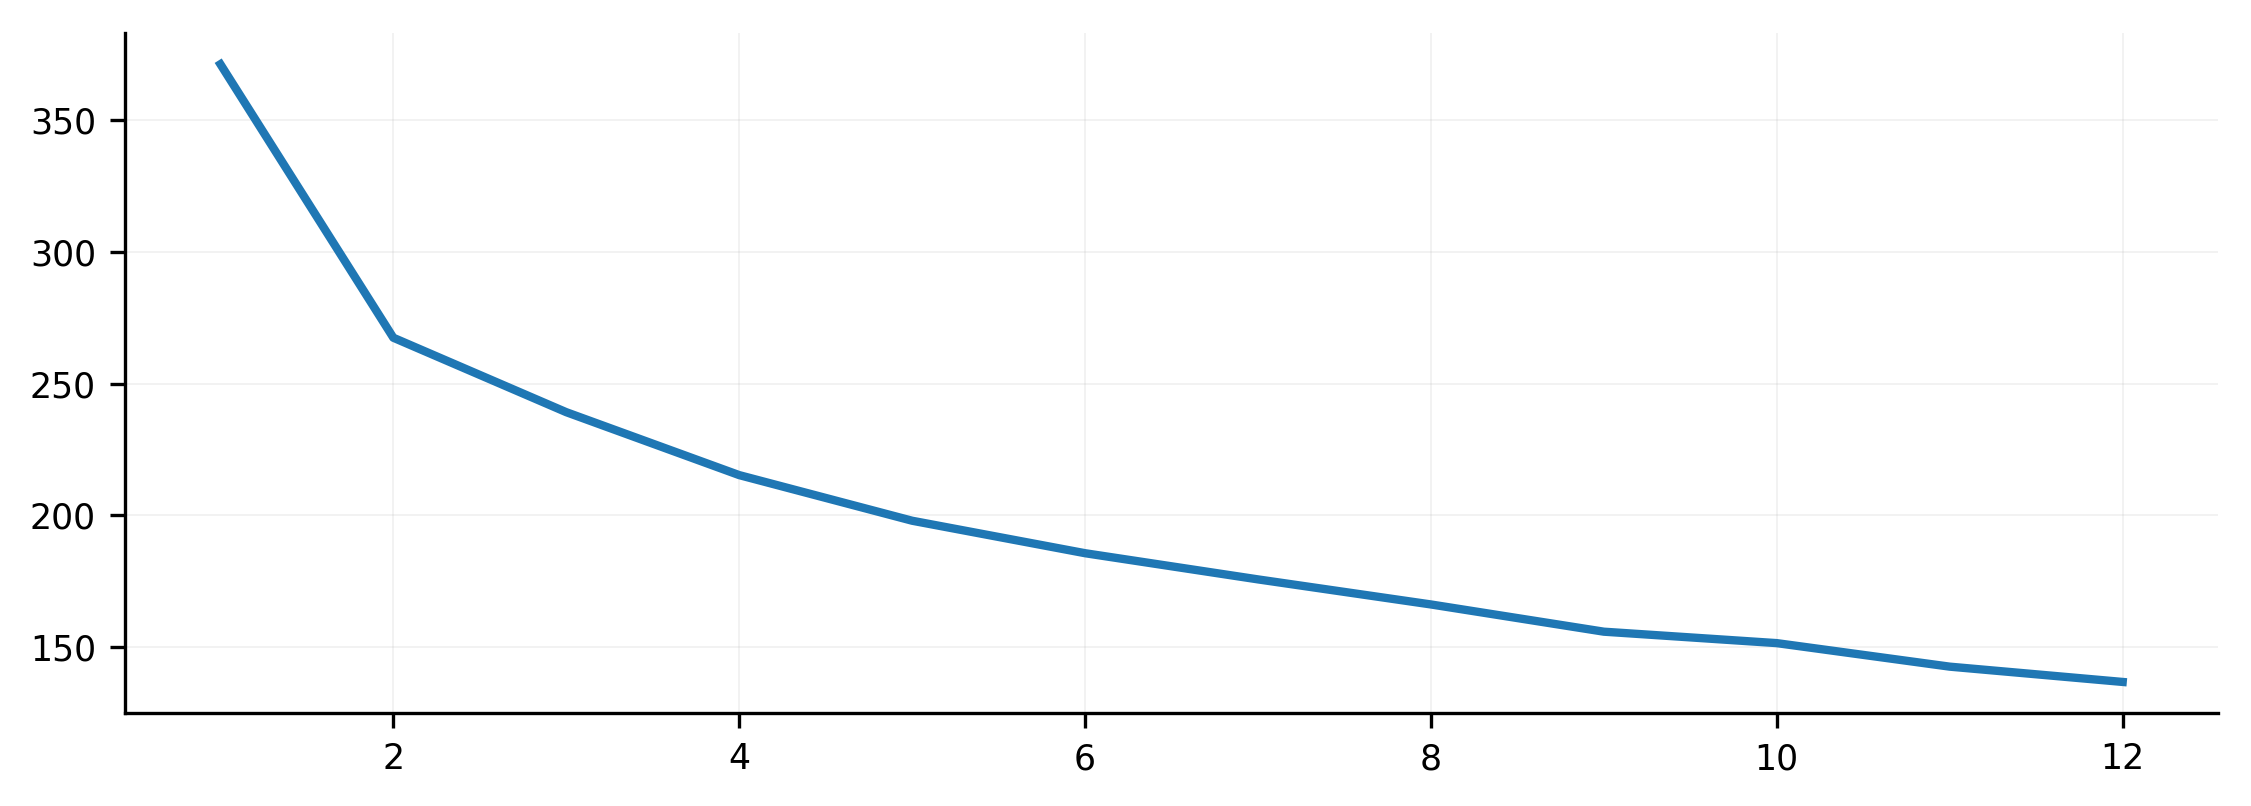

In [991]:
# What k should we choose for clustering? 
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
inertias = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values)
    inertias.append(kmeans.inertia_)
ax.plot(np.arange(1, 13), inertias, linewidth=2)

In [1010]:
nclus = 4
#kmeans = KMeans(n_clusters=nclus, random_state=0).fit(np.array([word_vecs[word] for word in word_vecs.keys()]))
kmeans = KMeans(n_clusters=nclus, random_state=0).fit(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values)
word_pcs['kmeans'] = kmeans.labels_
#word_pcs['cos_sim'] = np.mean(cos_sim(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), axis=-1)
word_pcs['cos_sim'] = np.mean(cos_sim(np.array([word_vecs[word] for word in word_vecs.keys()])), axis=-1)
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 74, 102,  34,  90]))


In [1034]:
in_dists = []
out_dists = []
for index, row in word_pcs.iterrows():
    vals = np.array(row[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values.tolist())
    cntr = kmeans.cluster_centers_[row.kmeans]
    in_dists.append(np.linalg.norm(vals - cntr))
    out_dists_ = []
    for k in [i for i in range(nclus) if i != row.kmeans]:
        cntr = kmeans.cluster_centers_[k]
        out_dists_.append(np.linalg.norm(vals - cntr))
    out_dists.append(np.mean(out_dists_))
word_pcs['in_dist'] = in_dists
word_pcs['out_dist'] = out_dists

In [1054]:
np.sort(stats.rankdata(word_pcs.loc[word_pcs.kmeans==0].in_dist) + stats.rankdata(-word_pcs.loc[word_pcs.kmeans==0].out_dist))

array([ 40.,  44.,  44.,  46.,  48.,  49.,  50.,  51.,  52.,  52.,  52.,
        55.,  55.,  56.,  58.,  58.,  60.,  61.,  61.,  62.,  62.,  64.,
        65.,  67.,  67.,  67.,  68.,  70.,  70.,  70.,  70.,  71.,  72.,
        73.,  73.,  75.,  75.,  75.,  77.,  77.,  78.,  78.,  78.,  80.,
        80.,  81.,  81.,  81.,  81.,  82.,  82.,  83.,  85.,  85.,  86.,
        86.,  86.,  86.,  90.,  90.,  90.,  92.,  93.,  97., 100., 100.,
       101., 101., 105., 105., 105., 108., 114., 118.])

In [1055]:
ranks = stats.rankdata(stats.rankdata(word_pcs.loc[word_pcs.kmeans==0].in_dist) + stats.rankdata(-word_pcs.loc[word_pcs.kmeans==0].out_dist))

In [1070]:
word_pcs['clustered'] = 0
clus_words = []
for k in range(nclus):
    n = int(len(word_pcs.query("kmeans=={}".format(k)))/2)
    ranks = stats.rankdata(stats.rankdata(word_pcs.loc[word_pcs.kmeans==k].in_dist) + stats.rankdata(-word_pcs.loc[word_pcs.kmeans==k].out_dist))
    clus_words += word_pcs.loc[word_pcs.kmeans==k, 'word'][ranks<(max(ranks)/2)].tolist()
word_pcs.loc[word_pcs.word.isin(clus_words), 'clustered'] = 1

In [1083]:
# PC 0: clothing, mad-made objects
# PC 1: ?
# PC 2: scenes, construction
# PC 3: food, cooking, eating, farm animals
for k in range(nclus):
    print(np.array(word_pcs.query("(kmeans=={}) & (clustered==True)".format(k)).sort_values('in_dist').word.tolist()))
    print('')

['BENCH' 'HAND' 'DOOR' 'WHEEL' 'SIGN' 'TRASH' 'POLE' 'FLOOR' 'GLOVE'
 'PURSE' 'ROOM' 'CHAIR' 'SUIT' 'BOY' 'STICK' 'SMOKE' 'PANTS' 'SHIRT'
 'DUCK' 'STREET' 'SINK' 'BOOK' 'HOLE' 'DRESS' 'PHONE' 'MOUTH' 'TRUCK'
 'SHOE' 'BOMB' 'STORE' 'BOWL' 'SHEET' 'BALL' 'BOARD' 'PLANE']

['JEEP' 'SNAIL' 'MUD' 'EAR' 'SLUSH' 'PALM' 'PIT' 'JAR' 'SPONGE' 'RAKE'
 'CORD' 'BLUSH' 'BEAK' 'EEL' 'CUBE' 'PASTE' 'SALT' 'HOSE' 'COIN' 'JET'
 'STAIR' 'ANT' 'SLIME' 'PET' 'NET' 'AXE' 'OWL' 'TIE' 'APE' 'BAT' 'WAND'
 'PEN' 'PEAR' 'PIPE' 'CAT' 'BEE' 'MAP' 'SOAP' 'MAT' 'LIP' 'NEST' 'RIB'
 'DART' 'LAMP' 'SAIL' 'PIN' 'STEM' 'PEA' 'ARM' 'ELF']

['CLIFF' 'CLAY' 'CRANE' 'ROSE' 'WALL' 'PARK' 'STONE' 'FORT' 'POOL'
 'SPRING' 'POND' 'HILL' 'BEACH' 'LAKE' 'RICE' 'WOOD']

['DRUM' 'PIG' 'PEACH' 'TENT' 'ROOF' 'ZOO' 'EGG' 'FLAME' 'DEER' 'SOCK'
 'JUICE' 'FACE' 'CAKE' 'BAG' 'HEART' 'TOAST' 'ROOT' 'SPOON' 'BEAN' 'INK'
 'CAGE' 'CONE' 'GRAPE' 'SWAMP' 'WHALE' 'COW' 'WING' 'SHRIMP' 'BED' 'CORN'
 'YARD' 'TOOL' 'ROPE' 'SMILE' 'CROW' 'MOTH' 'BARN'

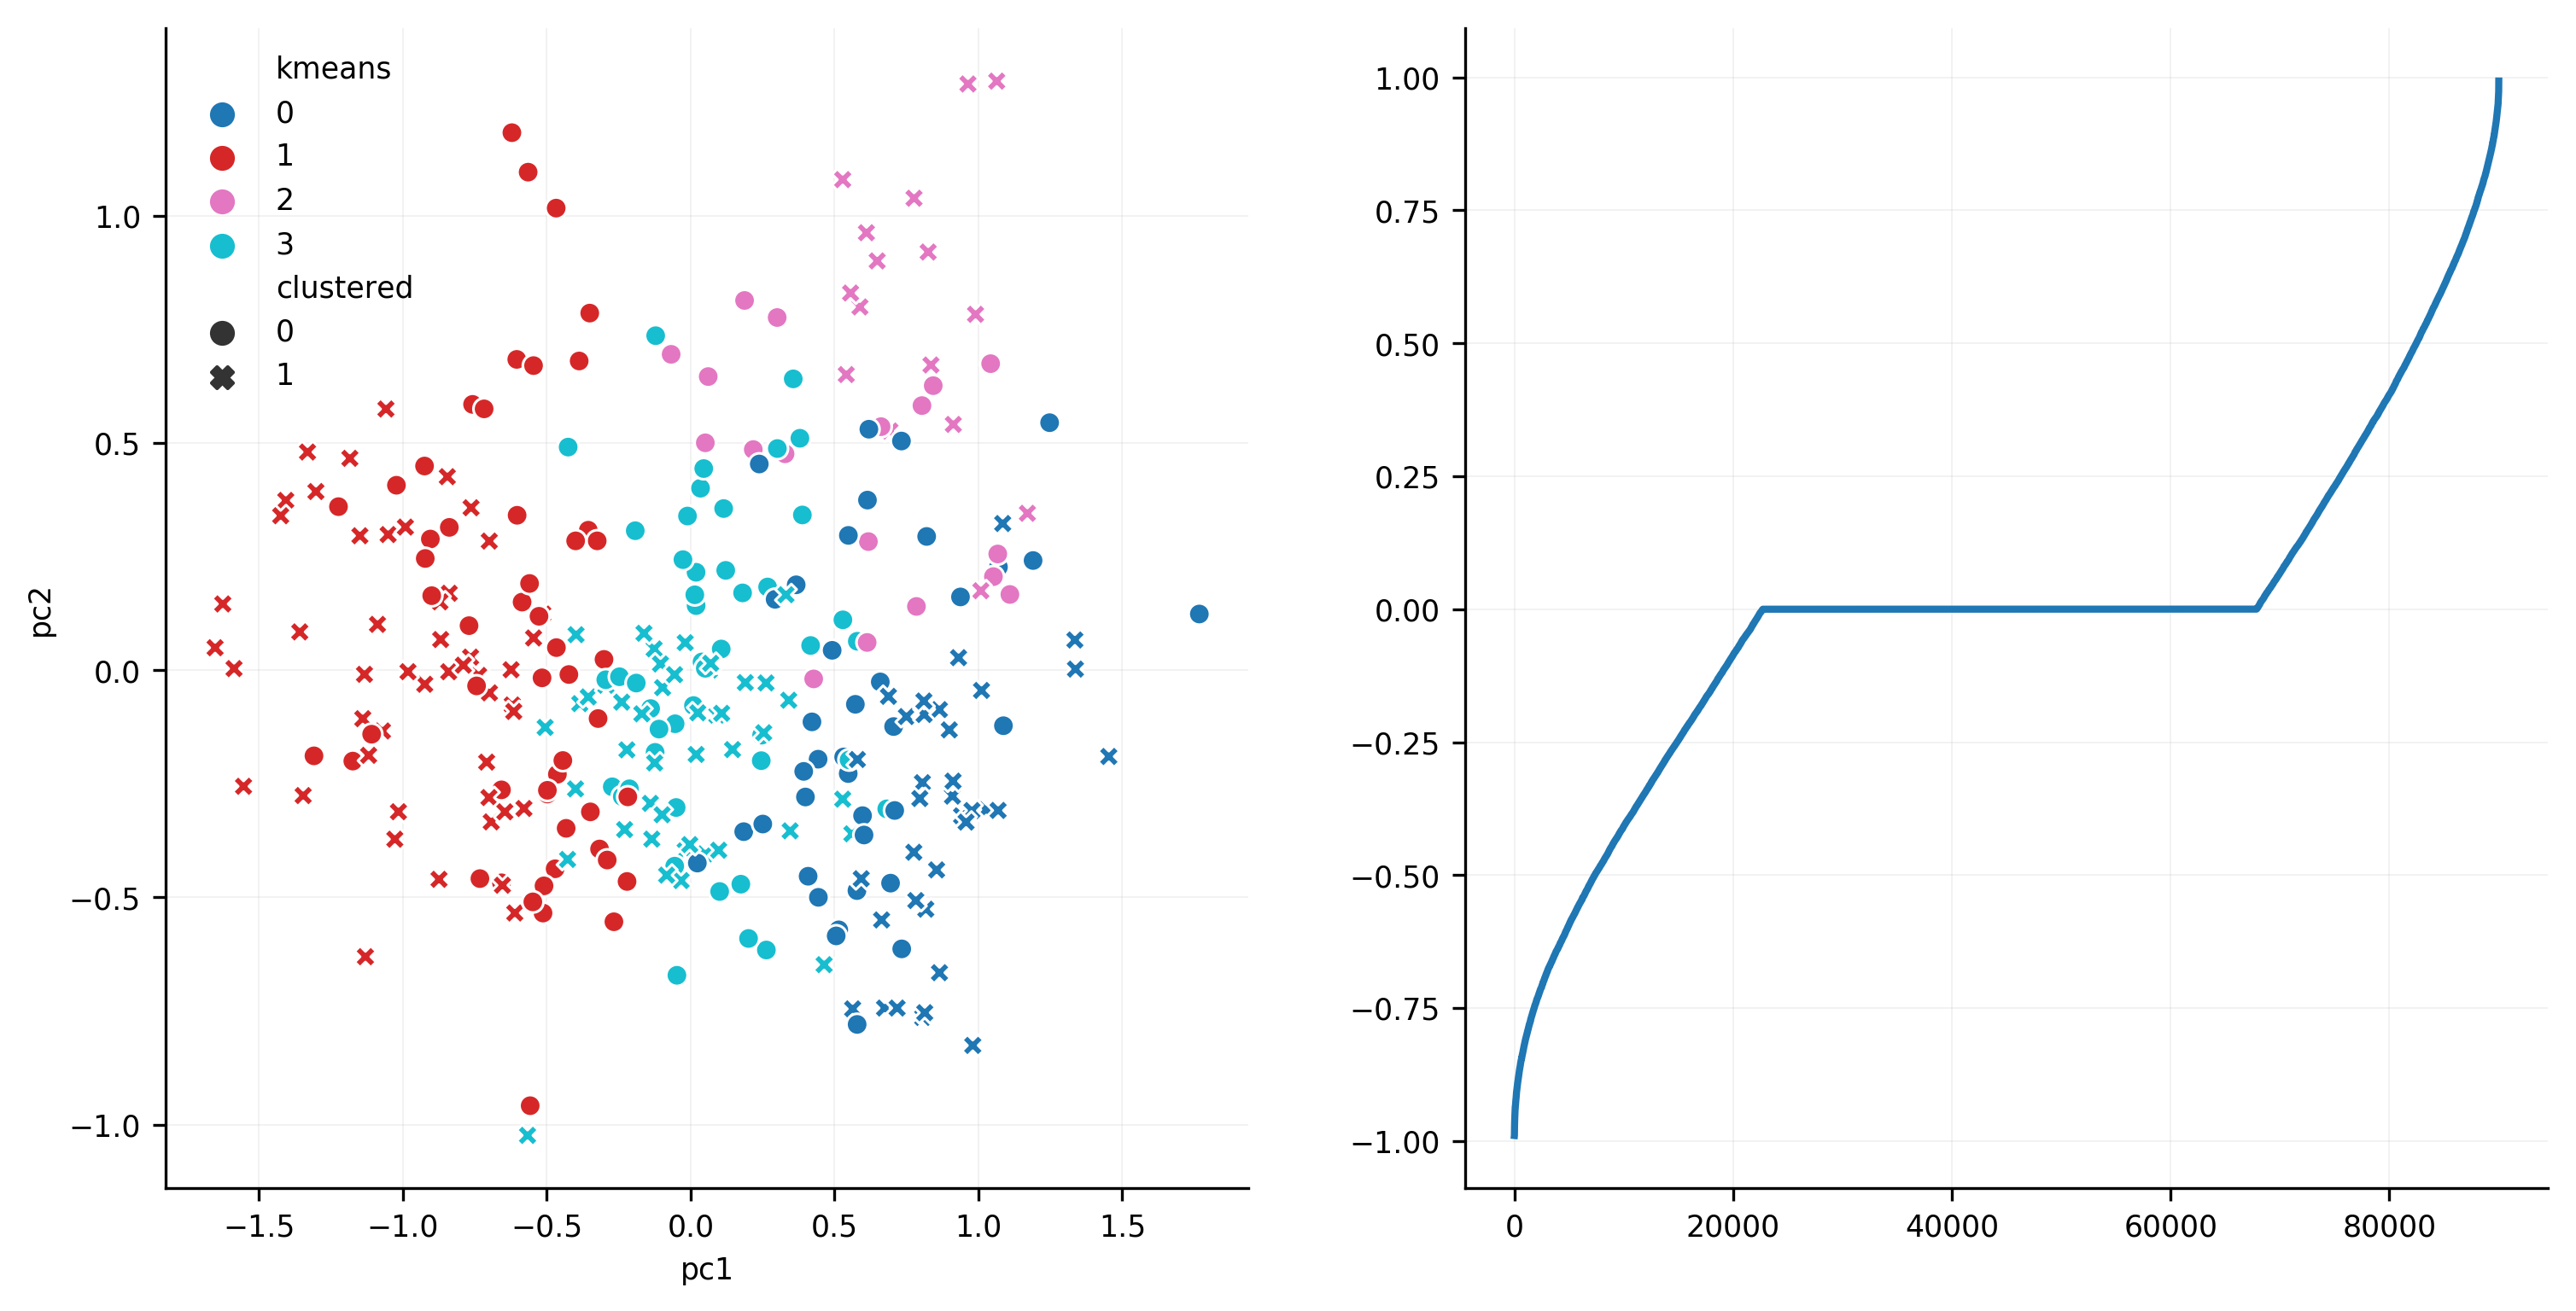

In [1084]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = np.ravel(ax)

sns.scatterplot(word_pcs.pc1, word_pcs.pc2, hue=word_pcs.kmeans, style=word_pcs.clustered, palette='tab10', legend='full', ax=ax[0])
ax[1].plot(np.sort(np.tril(cos_sim(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).flatten()), linewidth=2)

In [1025]:
print('All:', np.tril(cos_sim(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).mean())
for pc in np.unique(word_pcs.kmeans):
    mean_ = np.tril(cos_sim(word_pcs.query("kmeans=={}".format(pc))[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).mean()
    print('PC {}:'.format(pc), mean_)

All: -0.00036785842
PC 0: 0.26437074
PC 1: 0.23731208
PC 2: 0.260323
PC 3: 0.048009984


In [1027]:
print('All:', np.tril(cos_sim(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).mean())
for pc in np.unique(word_pcs.kmeans):
    mean_ = np.tril(cos_sim(word_pcs.query("(kmeans=={}) & (clustered==True)".format(pc))[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).mean()
    print('PC {}:'.format(pc), mean_)

All: -0.00036785842
PC 0: 0.33439922
PC 1: 0.2875893
PC 2: 0.3064188
PC 3: 0.061823945


In [1026]:
print('All:', np.tril(cos_sim(np.array([word_vecs[word] for word in word_vecs.keys()])), k=-1).mean())
for pc in np.unique(word_pcs.kmeans):
    words = word_pcs.query("kmeans=={}".format(pc)).word.tolist()
    mean_ = np.tril(cos_sim(np.array([word_vecs[word] for word in words])), k=-1).mean()
    print('PC {}:'.format(pc), mean_)

All: 0.16888957
PC 0: 0.23745632
PC 1: 0.12145283
PC 2: 0.20787685
PC 3: 0.19614266


In [963]:
np.array(word_pcs.sort_values('cos_sim', ascending=False).query("kmeans==3").word.tolist())

array(['SOCK', 'TAIL', 'CHALK', 'TOOTH', 'THREAD', 'CHEEK', 'SPOON',
       'SOUP', 'FUDGE', 'SWAMP', 'TENT', 'MOLE', 'GRAPE', 'YARD', 'TOAST',
       'BEAN', 'FENCE', 'WEED', 'SHRIMP', 'PEACH', 'HEN', 'DOCK', 'ROCK',
       'BROOM', 'STRAW', 'FLEA', 'JUICE', 'BARN', 'ROOF', 'SQUARE',
       'FARM', 'HEART', 'WING', 'CANE', 'CONE', 'STORM', 'SMILE', 'FACE',
       'VASE', 'WEB', 'WHALE', 'WOLF', 'CROW', 'FUR', 'MILK', 'MAZE',
       'GRASS', 'MOTH', 'BIRD', 'STEAM', 'DRUM', 'SHELL', 'CORN', 'CAKE',
       'TOOL', 'BREAD', 'EGG', 'FOOD', 'BOX', 'BAG', 'GOLD', 'LEG', 'FAN',
       'ROPE', 'DEER', 'ROOT', 'TREE', 'CHIN', 'FROG', 'CASH', 'CAGE',
       'RAIN', 'PIG', 'ZOO', 'HAWK', 'INK', 'CAVE', 'FLAME', 'FISH',
       'BEAR', 'BED', 'COW', 'CUP', 'SKI', 'SHARK', 'BRICK', 'TANK',
       'LAMB', 'VINE', 'GOAT'], dtype='<U6')

In [954]:
word1 = 'FOOD'
word2 = 'COW'
print(cos_sim2(word_vecs[word1], word_vecs[word2]), 
      cos_sim2(word_pcs.loc[word_pcs.word==word1, ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values.tolist()[0],
               word_pcs.loc[word_pcs.word==word2, ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values.tolist()[0]))

0.31052354 0.01670290814688117


In [923]:
word_pcs.sort_values('cos_sim', ascending=False).query("word=={}".format(['RAT', 'MOUSE']))

,word,pc1,pc2,pc3,pc4,pc5,pc6,kmeans,cos_sim
158,MOUSE,0.398676,-0.279009,0.217715,-0.062148,0.188129,-0.512716,3,0.440769
196,RAT,-0.657790,-0.263289,0.149576,0.140900,0.583250,-0.350402,2,0.302417


In [700]:
int(0.1 * len(word_pcs))

29

In [701]:
cos_sim2(word_vecs['HOUSE'], word_vecs['PARK'])

0.5408564

In [702]:
np.array([word_pcs.sort_values('pc1', ascending=True).word.tolist()[:int(0.1 * len(word_pcs))],
          word_pcs.sort_values('pc1', ascending=False).word.tolist()[:int(0.1 * len(word_pcs))]])

array([['ELF', 'STEM', 'ARM', 'PEA', 'NEST', 'DART', 'LAMP', 'APE',
        'MAP', 'OAR', 'SAIL', 'ICE', 'MAT', 'CART', 'BAT', 'BEE', 'PET',
        'LIP', 'SOAP', 'PIN', 'PIE', 'RIB', 'BEAK', 'CAT', 'PEN', 'PEAR',
        'TEA', 'JAR', 'WAND'],
       ['PLATE', 'BOWL', 'BALL', 'PLANE', 'ROAD', 'JUDGE', 'STONE',
        'BRANCH', 'PLANT', 'STREET', 'FILM', 'HOLE', 'HOUSE', 'LAKE',
        'GLASS', 'CHIEF', 'BOOK', 'BOARD', 'POND', 'PARK', 'DRESS',
        'FLOOR', 'HILL', 'ROOM', 'CHAIR', 'SCHOOL', 'BOY', 'SPRING',
        'SMOKE']], dtype='<U6')

In [704]:
np.array([word_pcs.sort_values('pc2', ascending=True).word.tolist()[:int(0.1 * len(word_pcs))],
          word_pcs.sort_values('pc2', ascending=False).word.tolist()[:int(0.1 * len(word_pcs))]])

array([['GOAT', 'WORM', 'DRESS', 'STEAK', 'MOUTH', 'SHEET', 'SHIRT',
        'PANTS', 'STICK', 'BREAD', 'STORE', 'SOUP', 'SOAP', 'GRASS',
        'FRUIT', 'CLOCK', 'TOOTH', 'SNAKE', 'SHEEP', 'TRAY', 'SHOE',
        'SLIME', 'FOAM', 'BOMB', 'TOE', 'PURSE', 'DITCH', 'THREAD',
        'DESK'],
       ['LAKE', 'HILL', 'WAVE', 'STAR', 'WOOD', 'BEACH', 'FLAG', 'ROSE',
        'POOL', 'FORT', 'RICE', 'BRIDGE', 'CRANE', 'SKY', 'PARK', 'BOAT',
        'HAWK', 'PEARL', 'CAPE', 'SUN', 'SHIP', 'CHIEF', 'CLIFF', 'WALL',
        'VAN', 'STORM', 'PRINCE', 'GATE', 'SEA']], dtype='<U6')

In [1086]:
print(word_pcs.sort_values('pc1').word.tolist()[:20])
print('')
print(word_pcs.sort_values('pc1', ascending=False).word.tolist()[:20])

['ELF', 'STEM', 'ARM', 'PEA', 'NEST', 'DART', 'LAMP', 'APE', 'MAP', 'OAR', 'SAIL', 'ICE', 'MAT', 'CART', 'BAT', 'BEE', 'PET', 'LIP', 'SOAP', 'PIN']

['PLATE', 'BOWL', 'BALL', 'PLANE', 'ROAD', 'JUDGE', 'STONE', 'BRANCH', 'PLANT', 'STREET', 'FILM', 'HOLE', 'HOUSE', 'LAKE', 'GLASS', 'CHIEF', 'BOOK', 'BOARD', 'POND', 'PARK']


## Linear SVM

In [1088]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [1090]:
X.shape, y.shape

((150, 4), (150,))

In [1093]:
OneVsRestClassifier(LinearSVC(penalty='l2', random_state=0)).fit(X, y).predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
LinearSVC(penalty='l2', multi_class='ovr', random_state=0).fit(X, y).predict(X)

In [1092]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
# 1. For each electrode, train a one-vs-all linear SVN classifier 
#    on all encoding trials to determine which category is best
#    predicted by that electrode.
# 2. Test whether the preferred category is predicted above chance
#    by performing repeated stratified shuffle-split cross-validation
#    10 times to obtain an accuracy measure (mean % correctly predicted
#    across CVs). Then compare this number to a shuffled distribution 
#    (N=100 shuffles).

## CatFR grouping

In [1308]:
# Get a list of all catFR1 words.
start_time = time()

import warnings
warnings.filterwarnings('ignore')
m = np.array([r1_df.loc[r1_df.experiment=='catFR1'].subject.tolist(),
              r1_df.loc[r1_df.experiment=='catFR1'].session.tolist()])
catfr1_words = []
catfr1_cats = []
for i in range(m.shape[1]):
    subj = m[0, i]
    sess = m[1, i]
    reader = CMLReader(subj, 'catFR1', sess)
    try:
        events = reader.load('events')
        new_words = events.loc[events.type=='WORD'].item_name.tolist()
        new_cats = events.loc[events.type=='WORD'].category.tolist()
        catfr1_words += new_words
        catfr1_cats += new_cats
    except:
        print('Missing events for {} sess {}'.format(subj, sess))
    
#catfr1_words = list(np.unique(catfr1_words))
#catfr1_cats = list(np.unique(catfr1_cats))
#print('Found {} unique words and {} unique categories'.format(len(catfr1_words), len(catfr1_cats)))
warnings.filterwarnings('default')

print('Done in {:.2f} secs'.format(time() - start_time))

Missing events for R1221P sess 0
Missing events for R1221P sess 1
Missing events for R1221P sess 2
Done in 18.99 secs


In [1399]:
catfr_dict = OrderedDict()
for i, cat in enumerate(catfr1_cats):
    if cat.lower() in catfr_dict:
        if catfr1_words[i] not in catfr_dict[cat.lower()]:
            catfr_dict[cat.lower()].append(catfr1_words[i])
    else:
        catfr_dict[cat.lower()] = [catfr1_words[i]]
del catfr_dict['x']

In [1401]:
catfr_vecs = OrderedDict()
count_in = 0
count_out = 0
for cat, words in catfr_dict.items():
    for word in words:
        try:
            if cat in catfr_vecs:
                catfr_vecs[cat] = catfr_vecs[cat] + model.get_vector(word)
            else:
                catfr_vecs[cat] = model.get_vector(word)
            count_in += 1
        except KeyError:
            count_out += 1
print(count_in, count_out)

360 257


In [1418]:
ncomp = 12
pca = PCA(n_components=ncomp)
word_pcs = pca.fit_transform(np.array([catfr_vecs[word] for word in list(catfr_vecs.keys())]))
#word_pcs = pd.DataFrame(word_pcs, index=list(catfr_vecs.keys()), columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']).reset_index()
cols = ['pc{}'.format(i+1) for i in range(ncomp)]
word_pcs = pd.DataFrame(word_pcs, index=list(catfr_vecs.keys()), columns=cols).reset_index()
word_pcs.rename(columns={'index': 'word'}, inplace=True)

print(word_pcs.shape, pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

(29, 13) [0.36899927 0.09292512 0.06788862 0.05240039 0.04143173 0.03397049
 0.03335973 0.03053317 0.02768824 0.02547424 0.02416806 0.02162001] 0.8204591


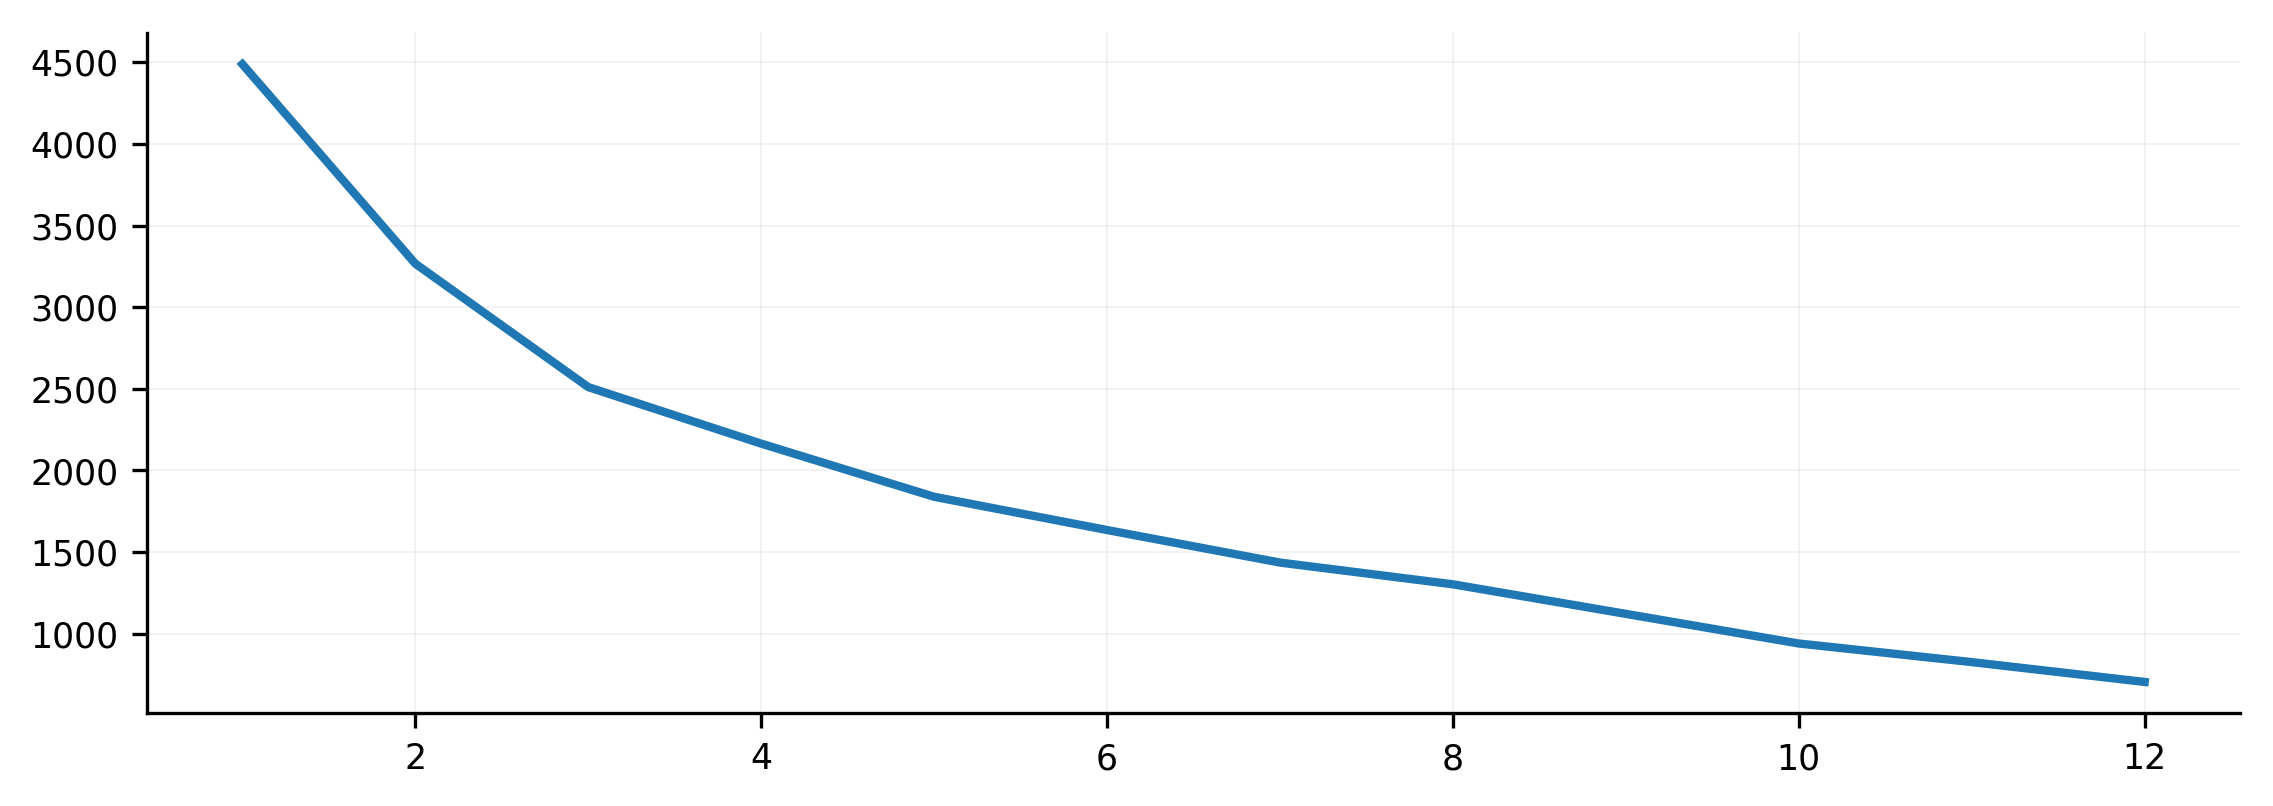

In [1419]:
# What k should we choose for clustering? 
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
inertias = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(word_pcs[cols].values)
    inertias.append(kmeans.inertia_)
ax.plot(np.arange(1, 13), inertias, linewidth=2)

In [1427]:
nclus = 5
kmeans = KMeans(n_clusters=nclus, random_state=0).fit(word_pcs[cols].values)
#kmeans = KMeans(n_clusters=nclus, random_state=0).fit(word_pcs[['pc1', 'pc2']].values)
word_pcs['kmeans'] = kmeans.labels_
word_pcs['cos_sim'] = np.mean(cos_sim(np.array([catfr_vecs[word] for word in catfr_vecs.keys()])), axis=-1)
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int32), array([ 1, 12,  1,  4, 11]))


In [1429]:
for k in range(nclus):
    print(np.array(word_pcs.query("(kmeans=={})".format(k)).word.tolist()))
    print('')

['beverages']

['furniture' 'vegetables' 'zoo' 'insects' 'officesupplies' 'appliances'
 'desserts' 'flowers' 'tools' 'oceananimals' 'instruments' 'fabric']

['landscapes']

['kitchentools' 'times' 'professions' 'materials']

['birds' 'vehicles' 'clothing' 'building' 'farmanimals' 'fruit' 'trees'
 'bodyparts' 'weather' 'toys' 'electronics']



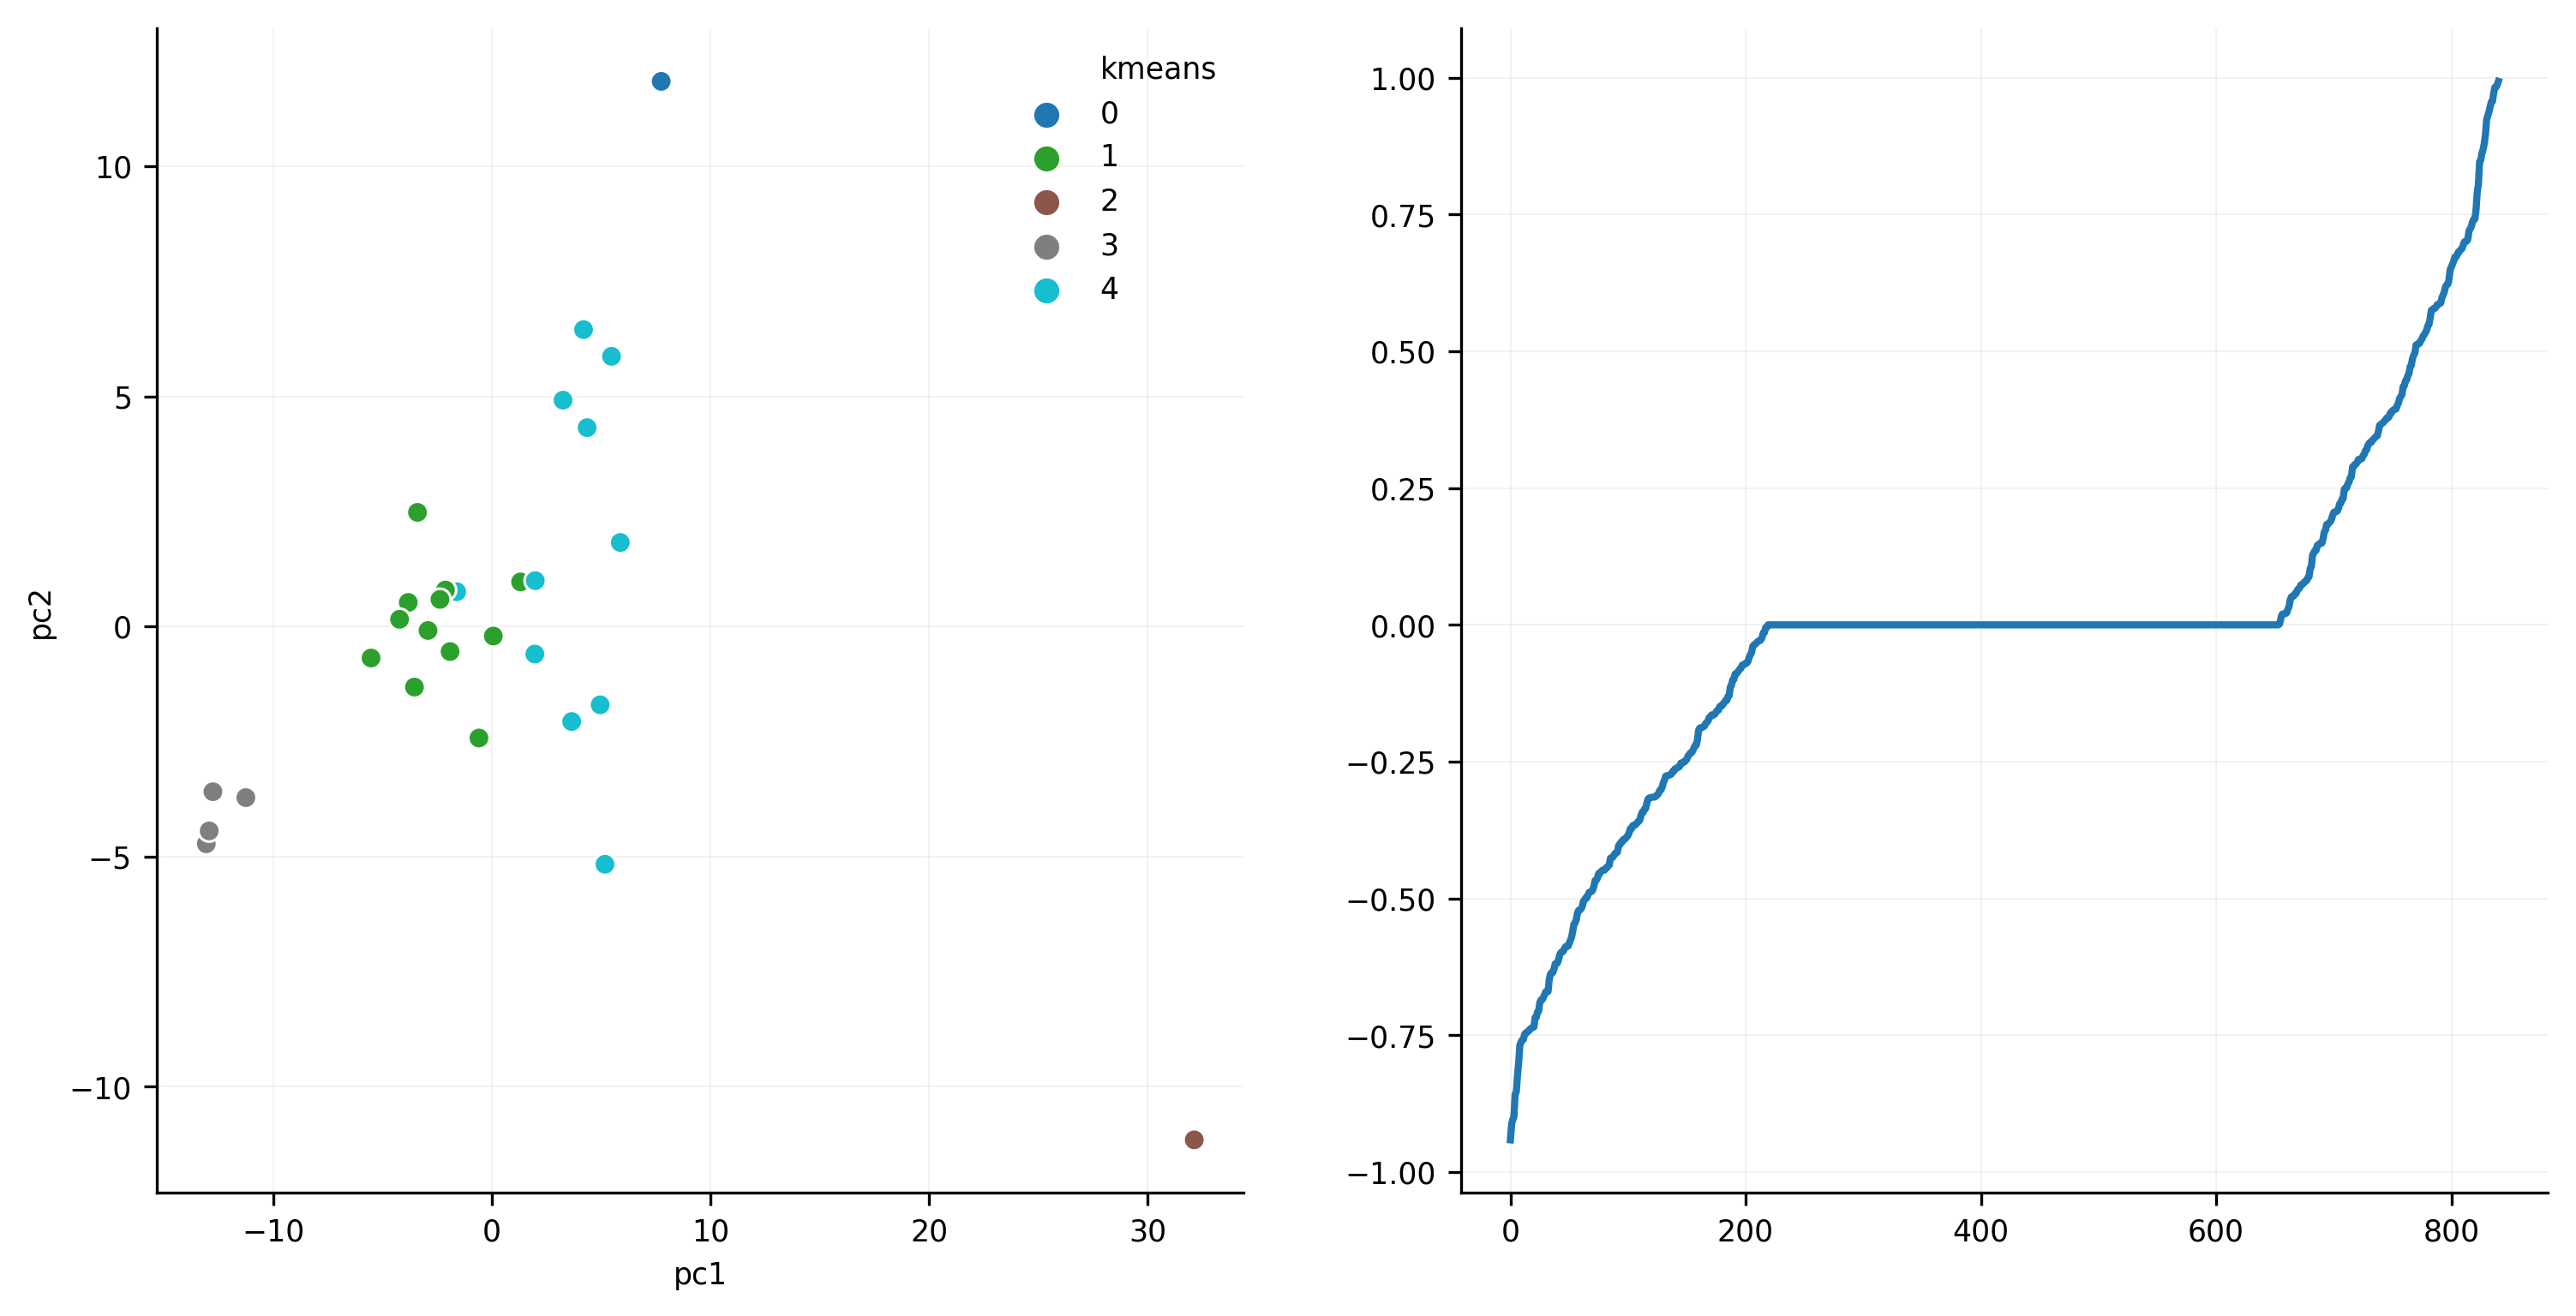

In [1428]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = np.ravel(ax)

sns.scatterplot(word_pcs.pc1, word_pcs.pc2, hue=word_pcs.kmeans, palette='tab10', legend='full', ax=ax[0])
ax[1].plot(np.sort(np.tril(cos_sim(word_pcs[['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']].values), k=-1).flatten()), linewidth=2)

In [1432]:
print(word_pcs.sort_values('pc1').head(5).word.tolist())
print(word_pcs.sort_values('pc1').tail(5).word.tolist())

['kitchentools', 'professions', 'materials', 'times', 'appliances']
['trees', 'farmanimals', 'fruit', 'beverages', 'landscapes']
